# Evaluating Notebook for the Time Windows Approach

In [1]:
import torch
from torch.utils.data import DataLoader
from utils import *
from tqdm import tqdm
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

model_dir = 'models/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
df_filtered = pd.read_csv("original_training_set_filtered.csv")
df_train = pd.read_csv("splits/train.csv")
df_val = pd.read_csv("splits/val.csv")
df_test = pd.read_csv("splits/test.csv")

# Preprocessing
feature_columns = [col for col in df_train.columns if col not in ["label", "exp_name"]]
scaler = StandardScaler()
scaler.fit(df_train[feature_columns])
mean = scaler.mean_
std = scaler.scale_

# Label encoding
exp_labels = df_filtered.groupby("exp_name")["label"].first()
label_encoder = LabelEncoder()
label_encoder.fit(exp_labels.values)
exp_name_to_label = exp_labels.to_dict()

# Dataset creation with overlap
N = 100
train_dataset = SensorDataset(df_train, exp_name_to_label, label_encoder, mean, std, N=N)
val_dataset   = SensorDataset(df_val,   exp_name_to_label, label_encoder, mean, std, N=N)
test_dataset  = SensorDataset(df_test,  exp_name_to_label, label_encoder, mean, std, N=N)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

$\text{Common hyperparameters: }$
- Learning rate: $1 \times 10^{-4}$
- Weight decay: $1 \times 10^{-5}$
- Dropout: $0.2$

$\ $

$
\text{Common MLP Block: } 
[\text{Dropout}(p=0.2) \rightarrow \text{Linear}(64, 19)]
$

### Simple MLP


$
\text{Input: } \mathbb{R}^{100 \times 16}
\rightarrow \text{Flatten} \rightarrow \mathbb{R}^{1600}
\rightarrow \text{Linear}(1600, 64)
\rightarrow [\text{Common MLP Block}]
$

In [3]:
model_path = os.path.join(model_dir, "MLP_h64_10052025_1536.ckpt")

sample_train_cm, train_exp_stats = get_stats(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance(test_exp_stats)

100%|██████████| 1272/1272 [01:02<00:00, 20.47it/s]


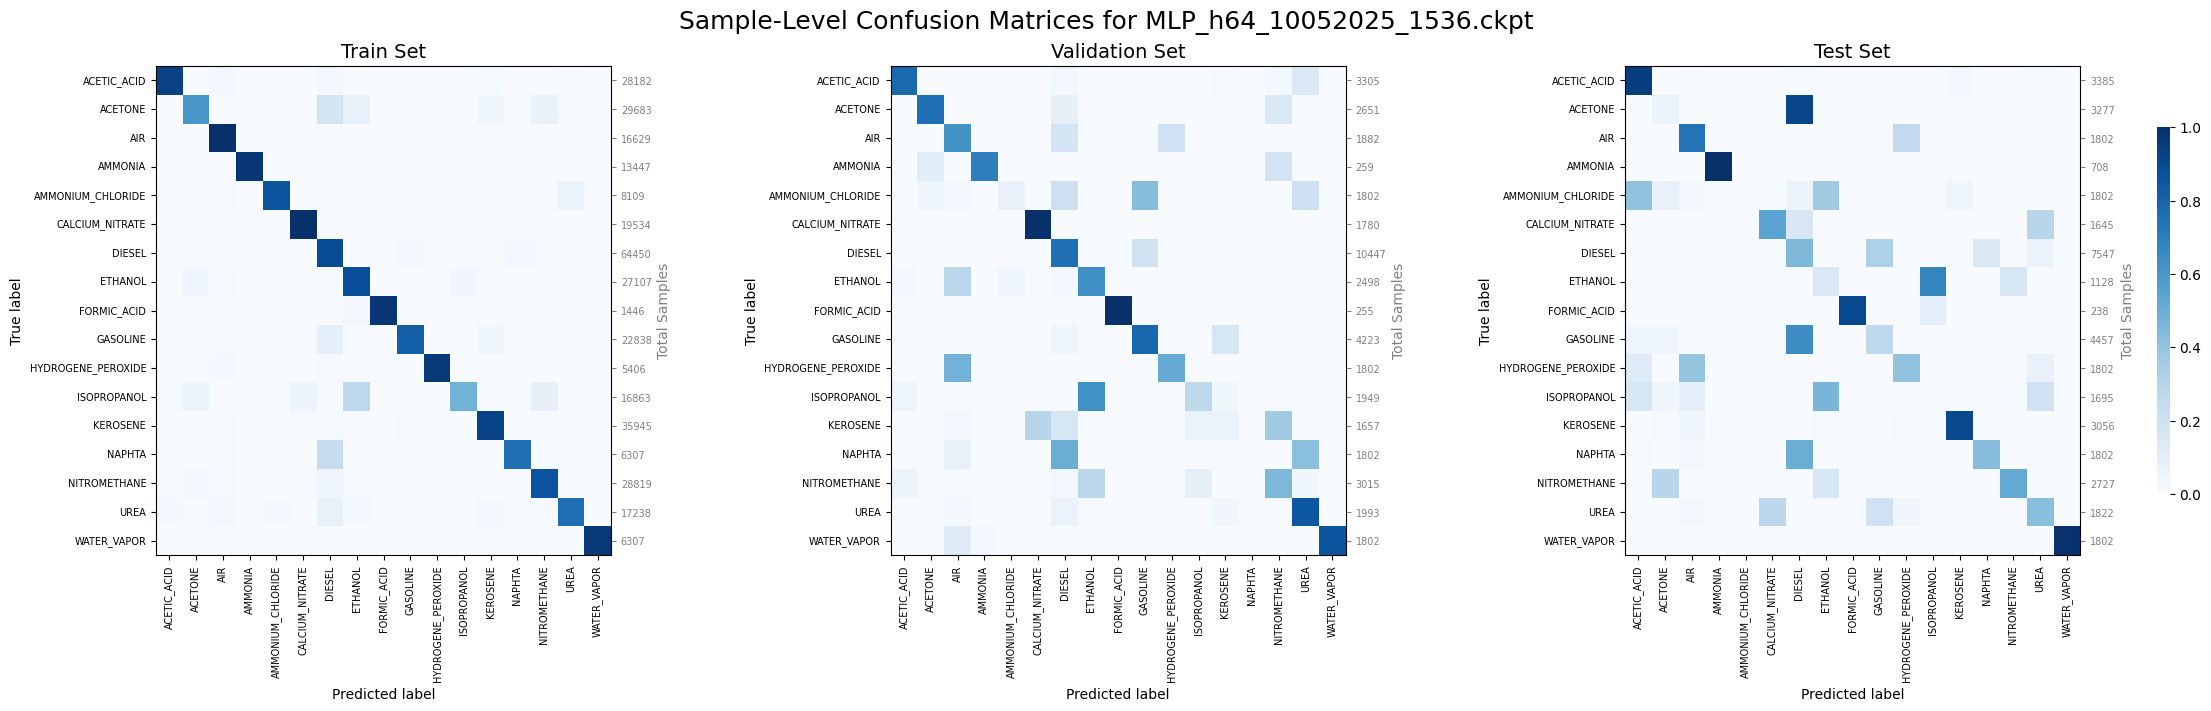

Train Performance: 0.9026548672566371
Validation Performance: 0.6829268292682927
Test Performance: 0.5365853658536586


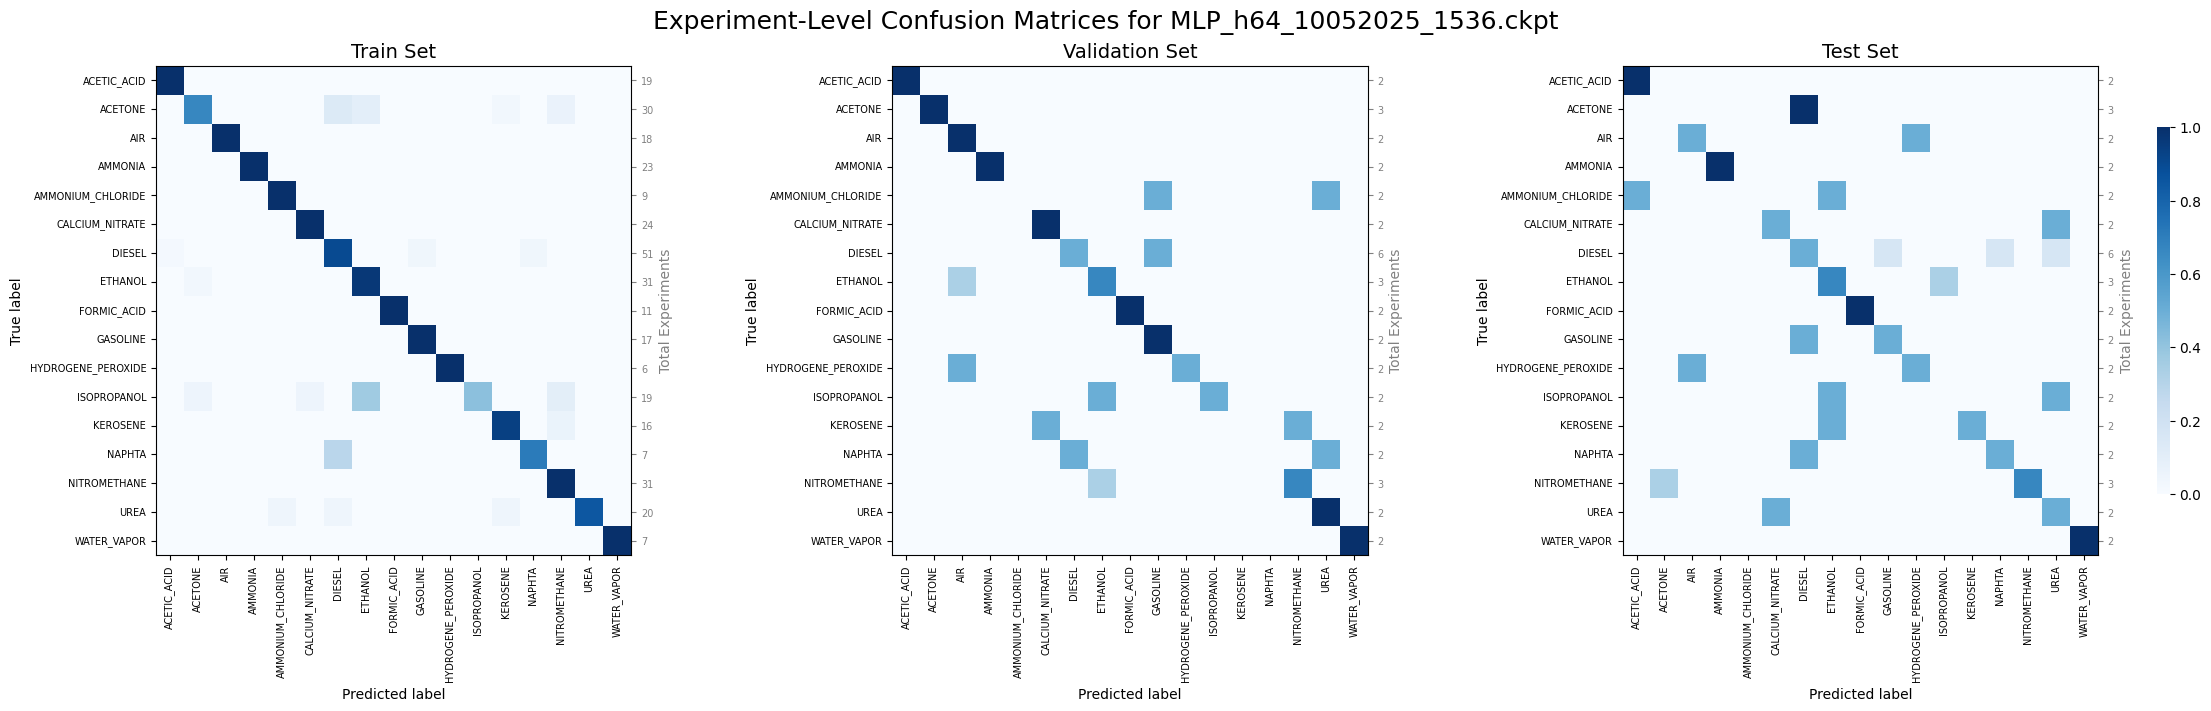

In [4]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
    )


In [3]:
model_path = os.path.join(model_dir, "MLP_h64_10052025_1536.ckpt")

sample_train_cm, train_exp_stats = get_stats_f1(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance_f1(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats_f1(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance_f1(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats_f1(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance_f1(test_exp_stats)

100%|██████████| 1272/1272 [01:12<00:00, 17.44it/s]


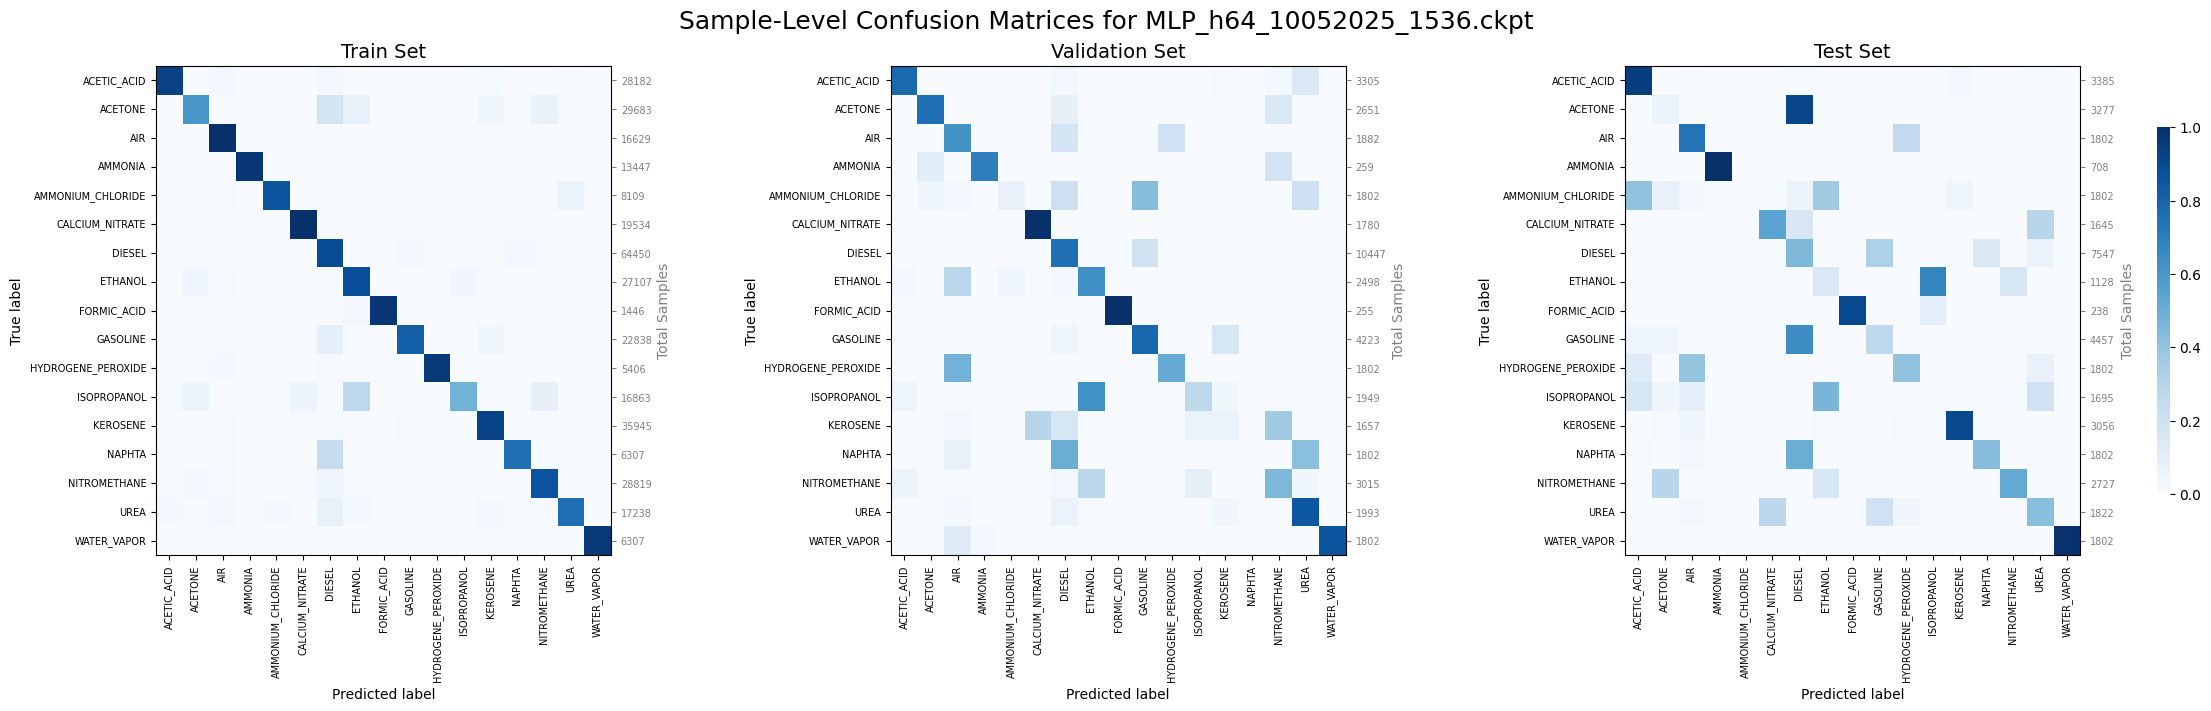

Train Performance: 0.8997050147492626
Validation Performance: 0.7317073170731707
Test Performance: 0.5365853658536586


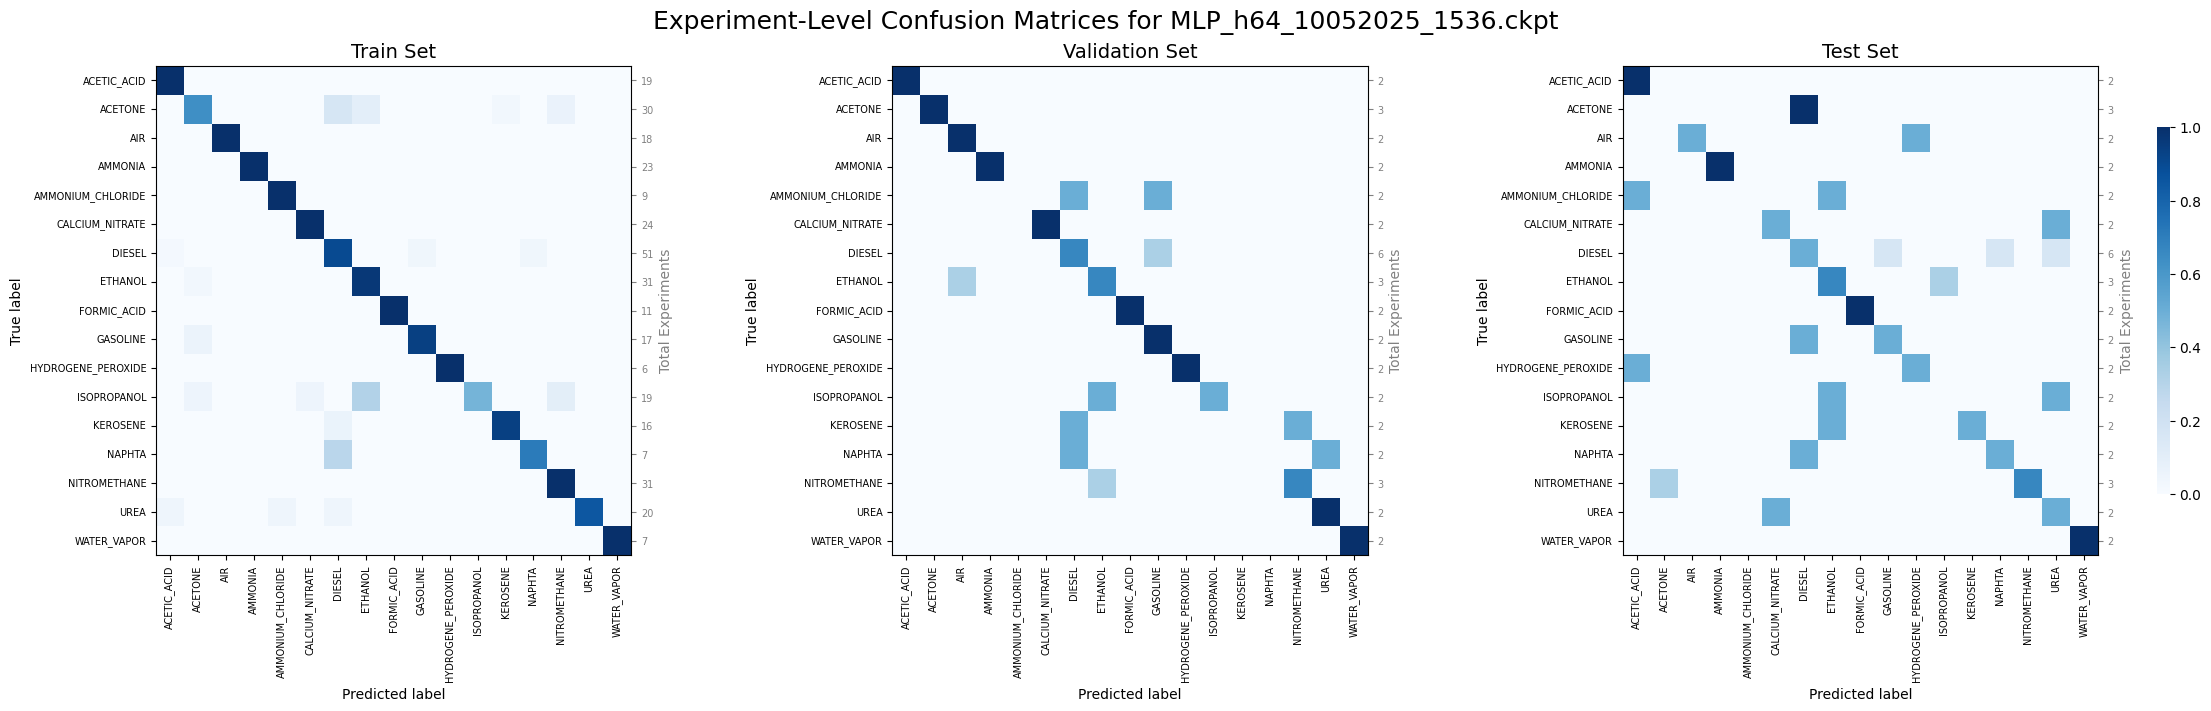

In [4]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

### Encoder + MLP

$
\text{Input: } \mathbb{R}^{100 \times 16}
\rightarrow \text{Flatten} \rightarrow \mathbb{R}^{1600}
\rightarrow \text{Linear}(1600, 80)
\rightarrow \text{Linear}(80, 64)
\rightarrow [\text{Common MLP Block}]
$


In [5]:
model_path = os.path.join(model_dir, "EMLP_h64_l80_10052025_0459.ckpt")

sample_train_cm, train_exp_stats = get_stats(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance(test_exp_stats)

100%|██████████| 1272/1272 [01:01<00:00, 20.68it/s]


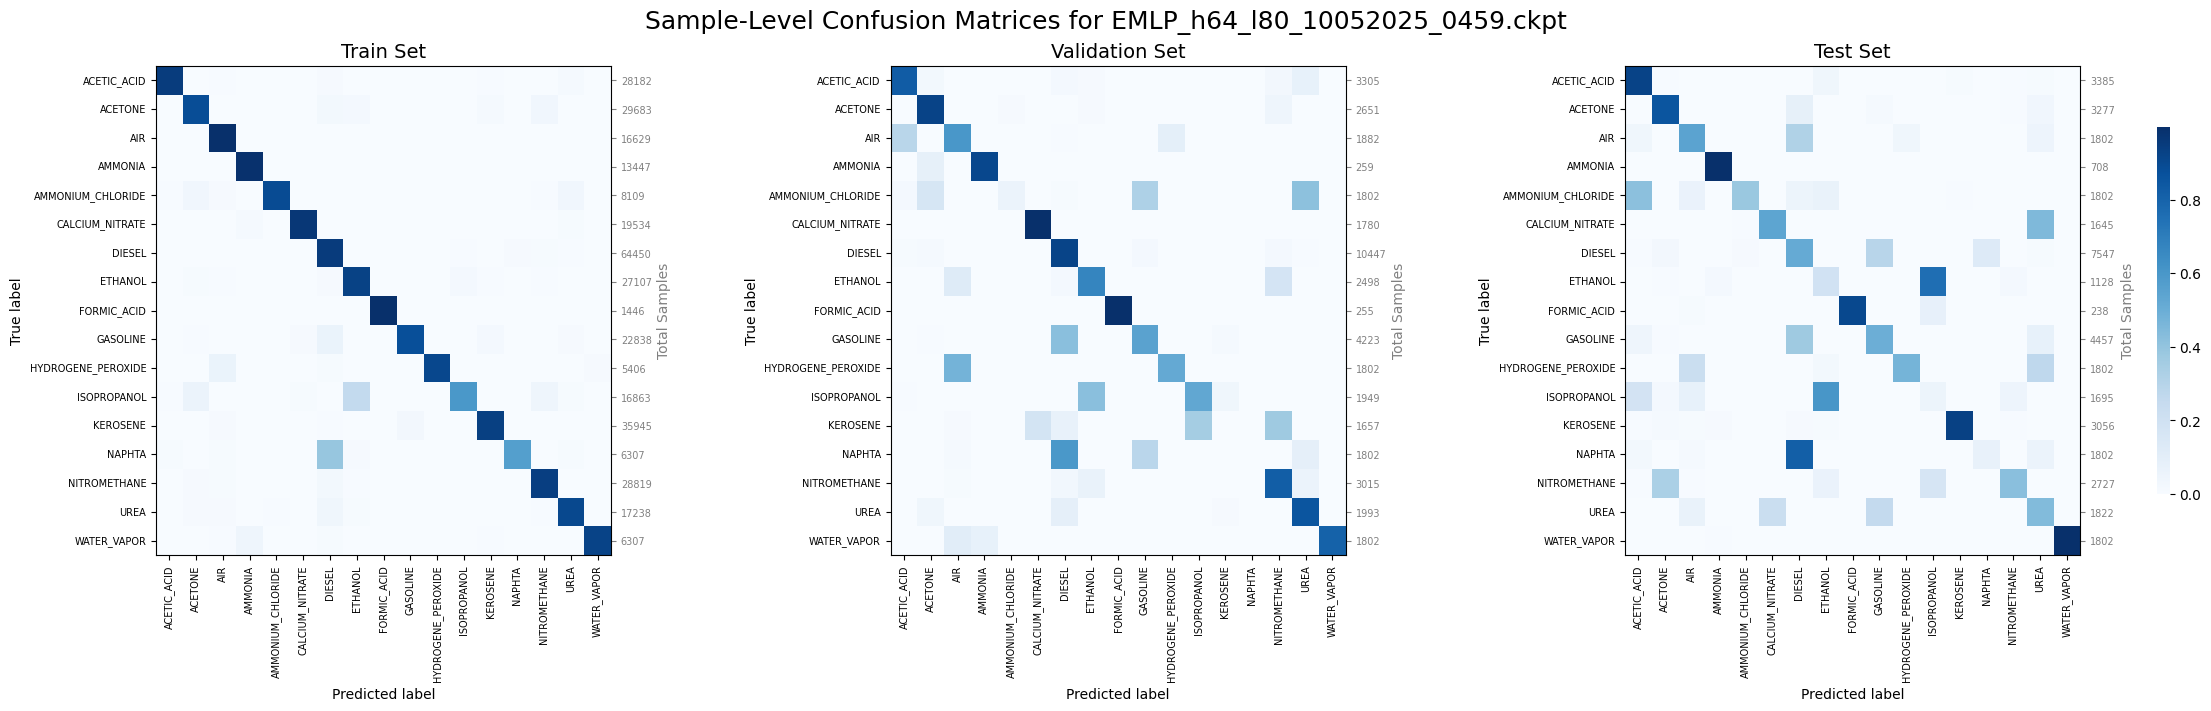

Train Performance: 0.9557522123893806
Validation Performance: 0.7804878048780488
Test Performance: 0.6341463414634146


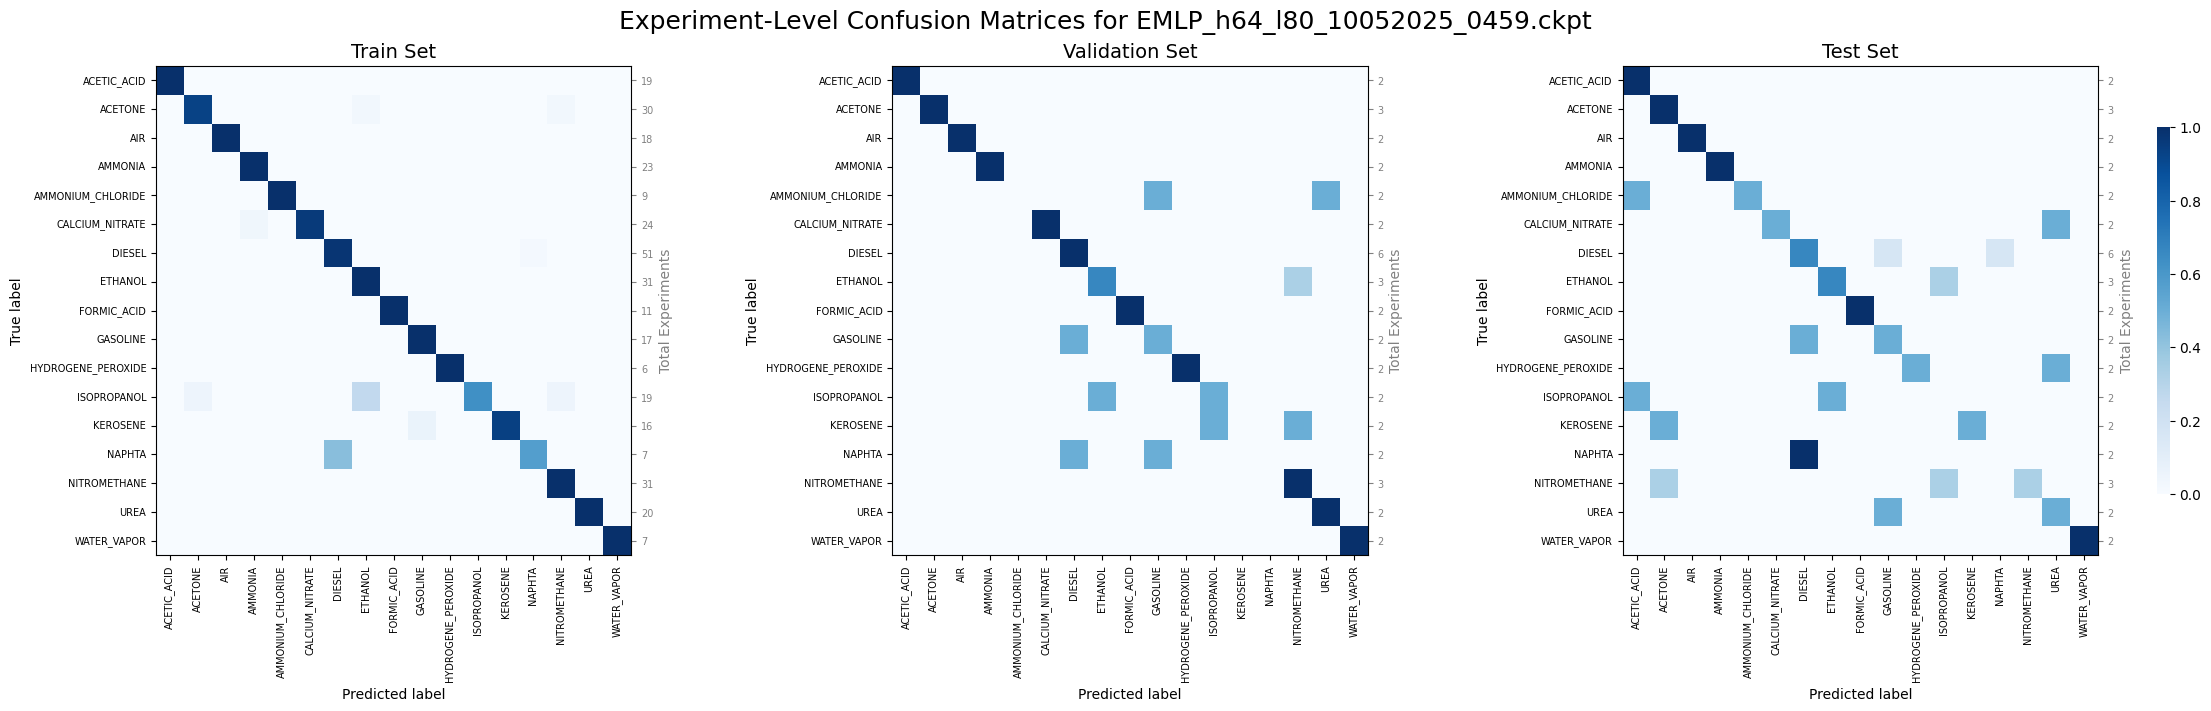

In [6]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

In [5]:
model_path = os.path.join(model_dir, "EMLP_h64_l80_10052025_0459.ckpt")

sample_train_cm, train_exp_stats = get_stats_f1(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance_f1(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats_f1(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance_f1(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats_f1(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance_f1(test_exp_stats)

100%|██████████| 1272/1272 [01:11<00:00, 17.90it/s]


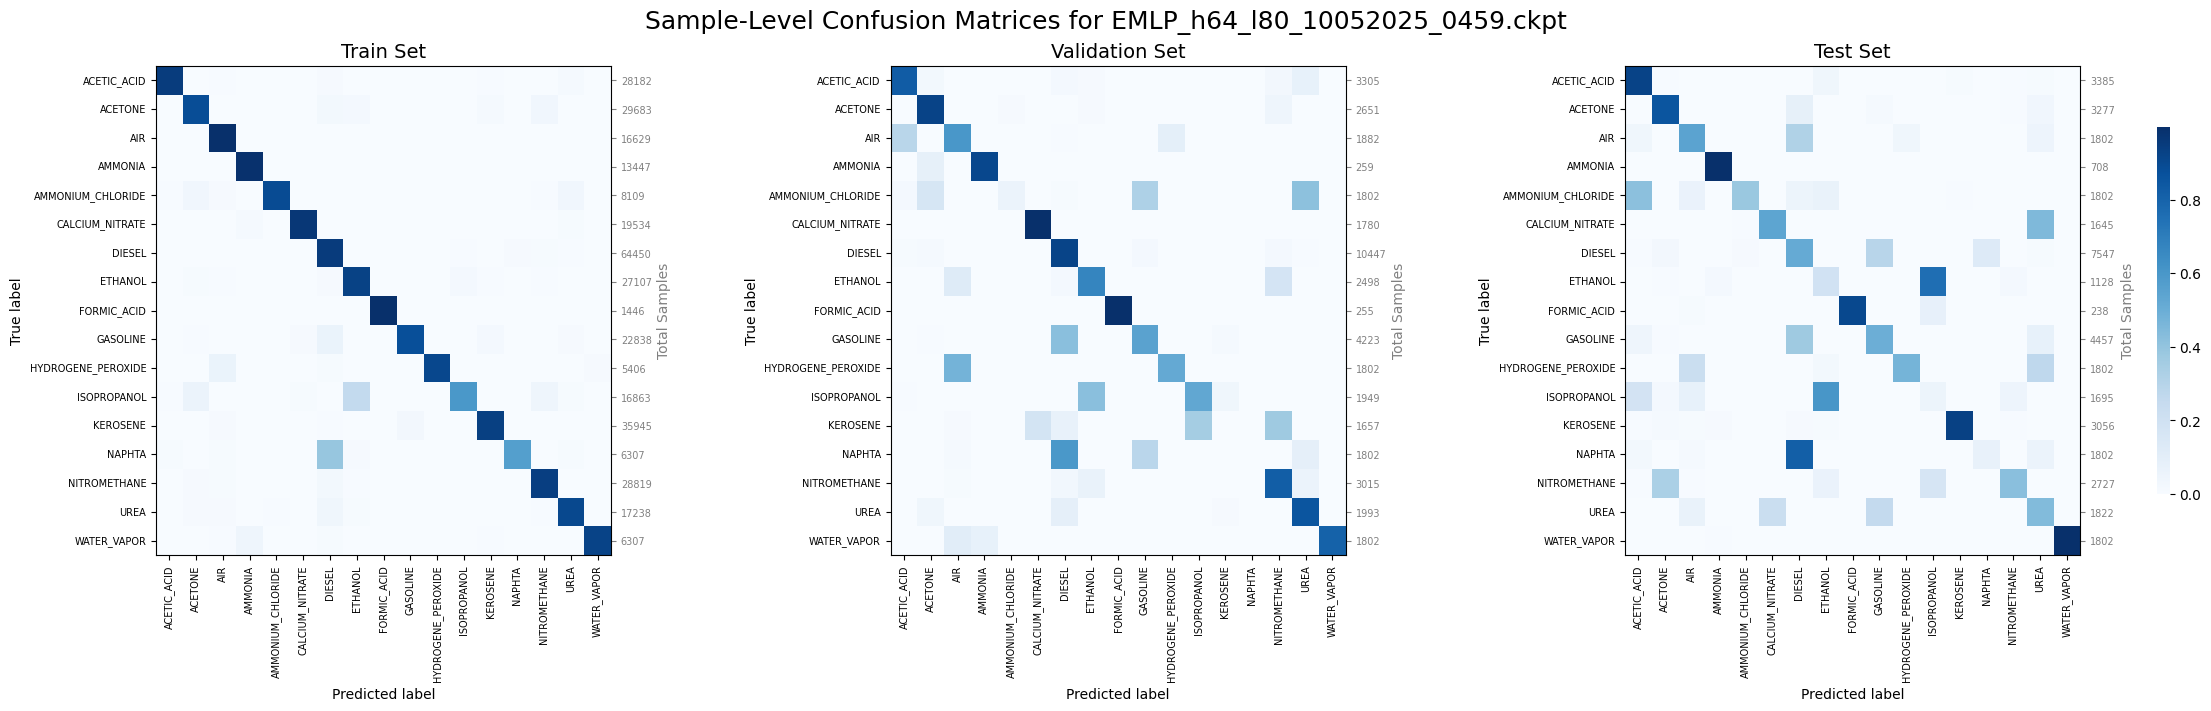

Train Performance: 0.9557522123893806
Validation Performance: 0.7560975609756098
Test Performance: 0.6097560975609756


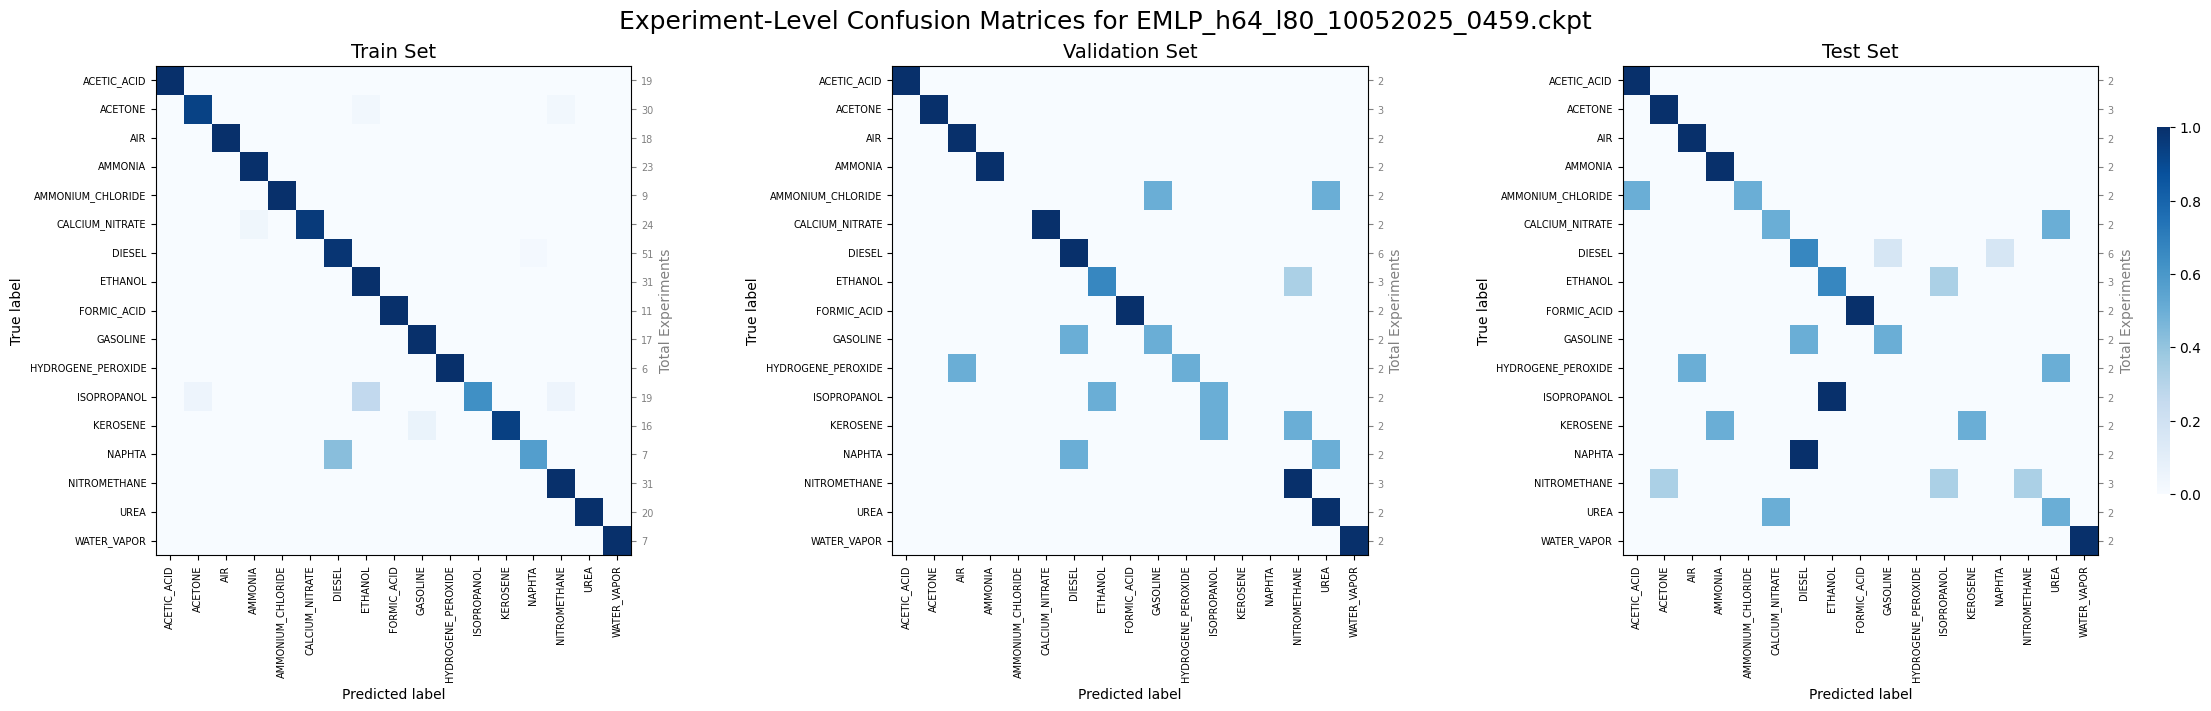

In [6]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

$
\text{Input: } \mathbb{R}^{100 \times 16}
\rightarrow \text{Flatten} \rightarrow \mathbb{R}^{1600}
\rightarrow \text{Linear}(1600, 20)
\rightarrow \text{Linear}(20, 64)
\rightarrow [\text{Common MLP Block}]
$

In [7]:
model_path = os.path.join(model_dir, "EMLP_h64_l20_10052025_1421.ckpt")

sample_train_cm, train_exp_stats = get_stats(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance(test_exp_stats)

100%|██████████| 1272/1272 [01:02<00:00, 20.29it/s]


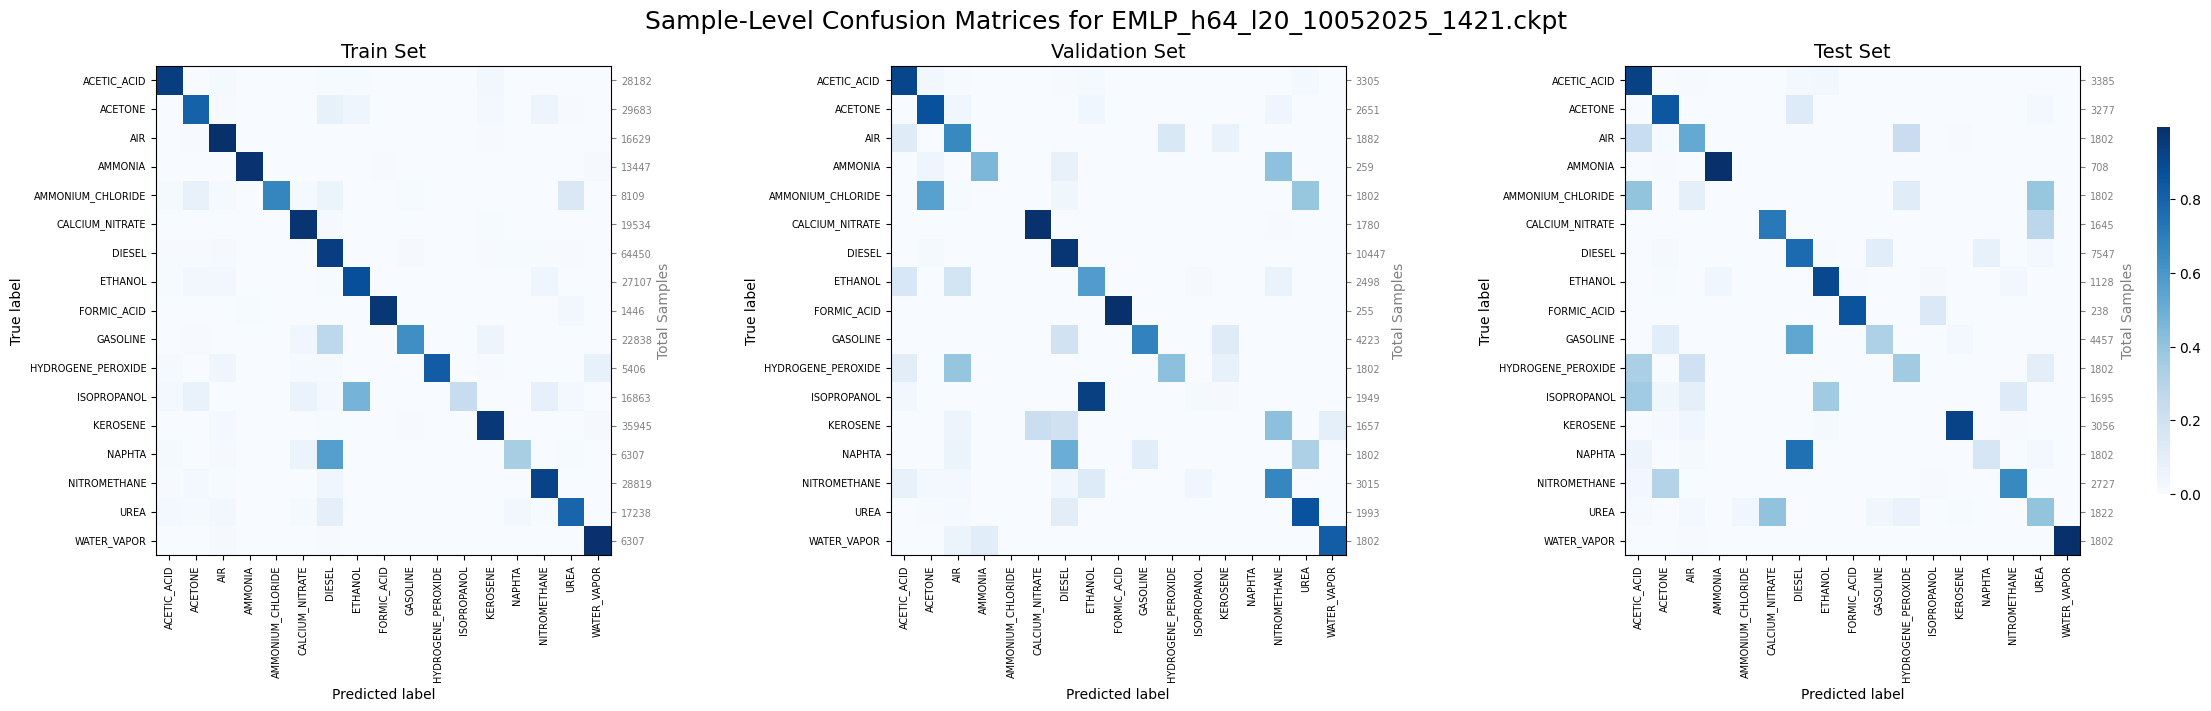

Train Performance: 0.8849557522123894
Validation Performance: 0.7073170731707317
Test Performance: 0.6829268292682927


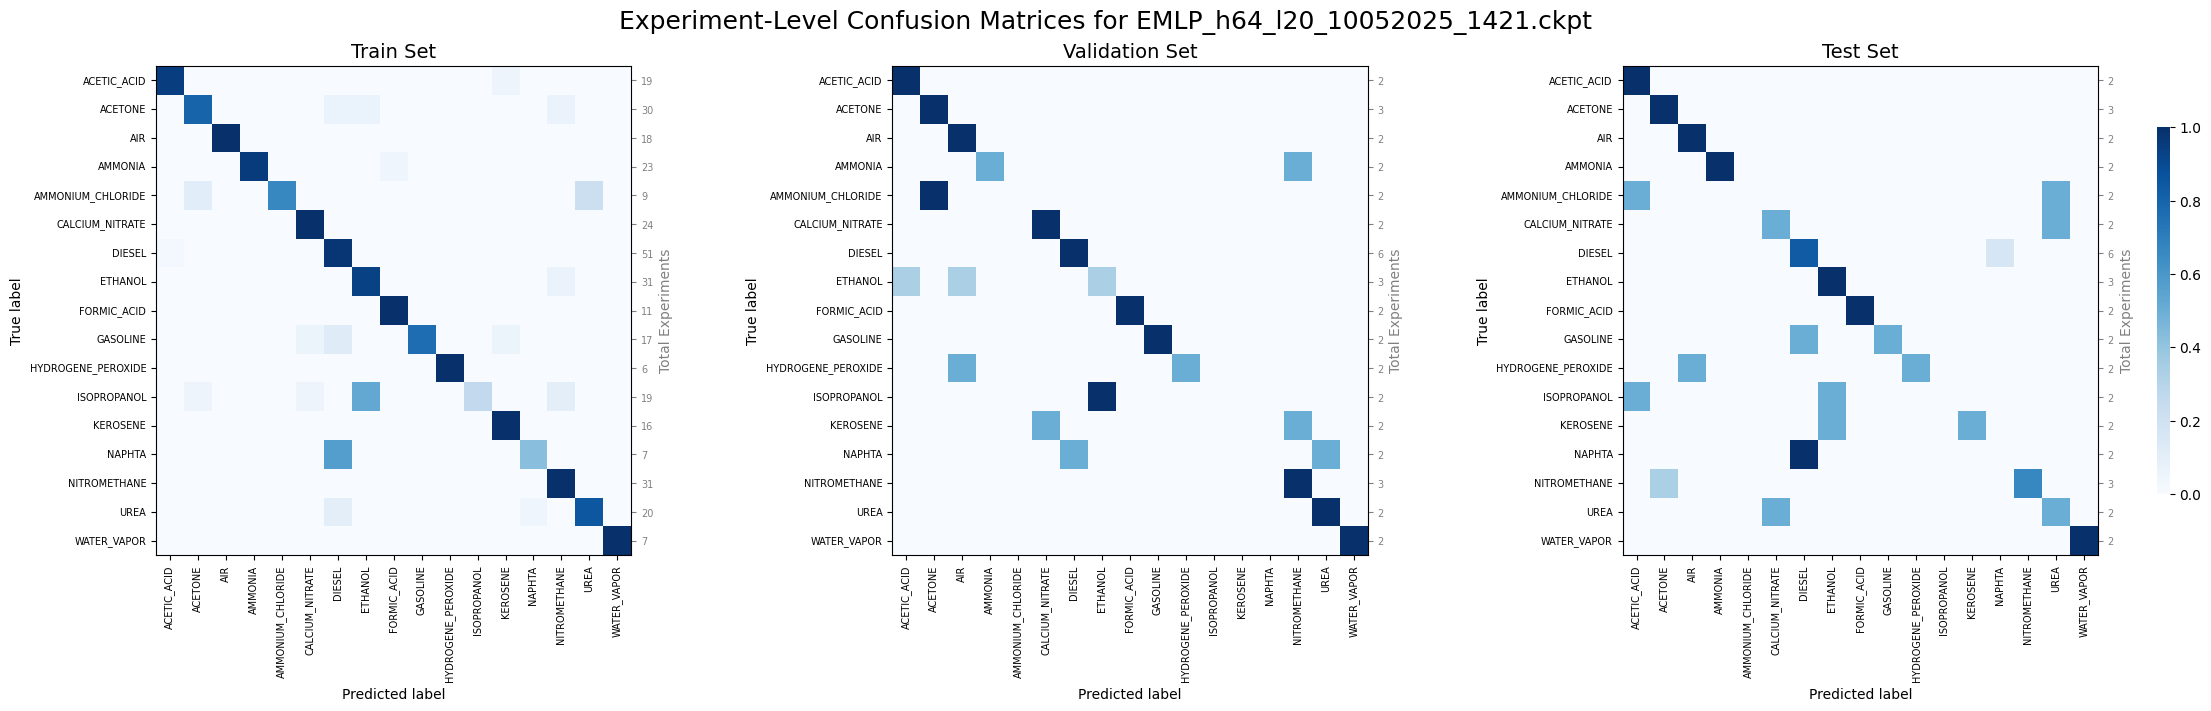

In [8]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

In [7]:
model_path = os.path.join(model_dir, "EMLP_h64_l20_10052025_1421.ckpt")

sample_train_cm, train_exp_stats = get_stats_f1(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance_f1(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats_f1(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance_f1(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats_f1(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance_f1(test_exp_stats)

100%|██████████| 1272/1272 [01:16<00:00, 16.66it/s]


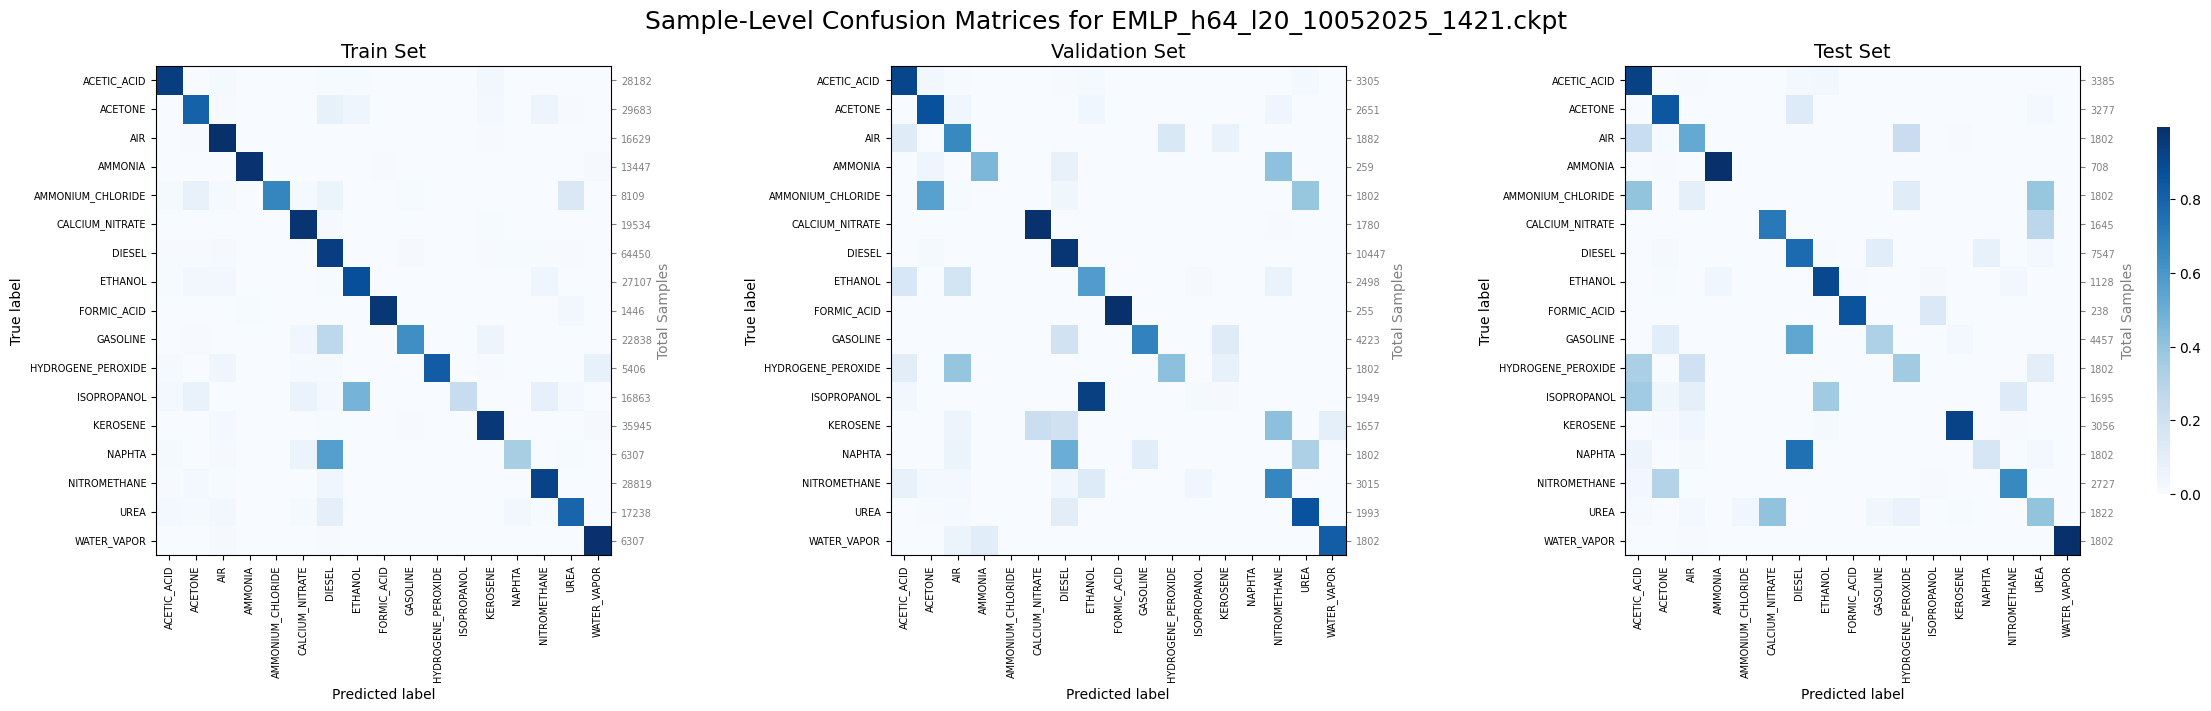

Train Performance: 0.8820058997050148
Validation Performance: 0.7317073170731707
Test Performance: 0.6341463414634146


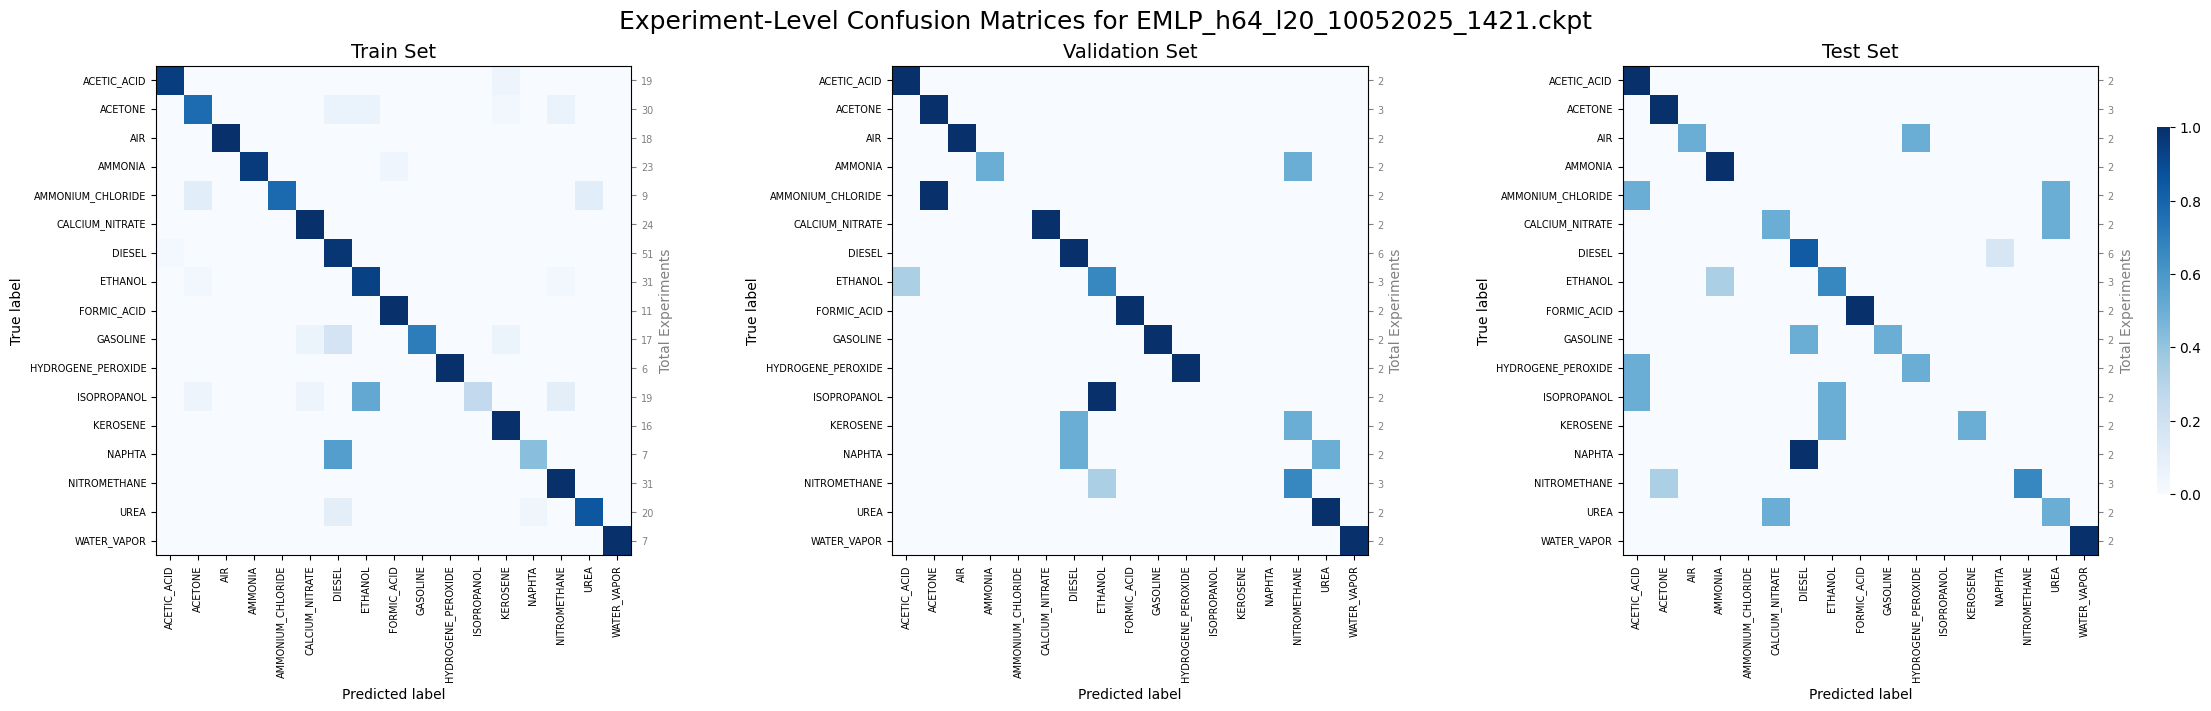

In [8]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

### Column Selective Encoder + MLP

$
\text{Input: } \mathbb{R}^{100 \times 16}
\rightarrow \text{Column Selective Encoder}(5, 3) \rightarrow \mathbb{R}^{5*16+3}
\rightarrow \text{Linear}(83, 64)
\rightarrow [\text{Common MLP Block}]
$

In [9]:
model_path = os.path.join(model_dir, "CSEMLP_h64_m5_k3_10052025_0146.ckpt")

sample_train_cm, train_exp_stats = get_stats(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance(test_exp_stats)

100%|██████████| 1272/1272 [01:02<00:00, 20.23it/s]


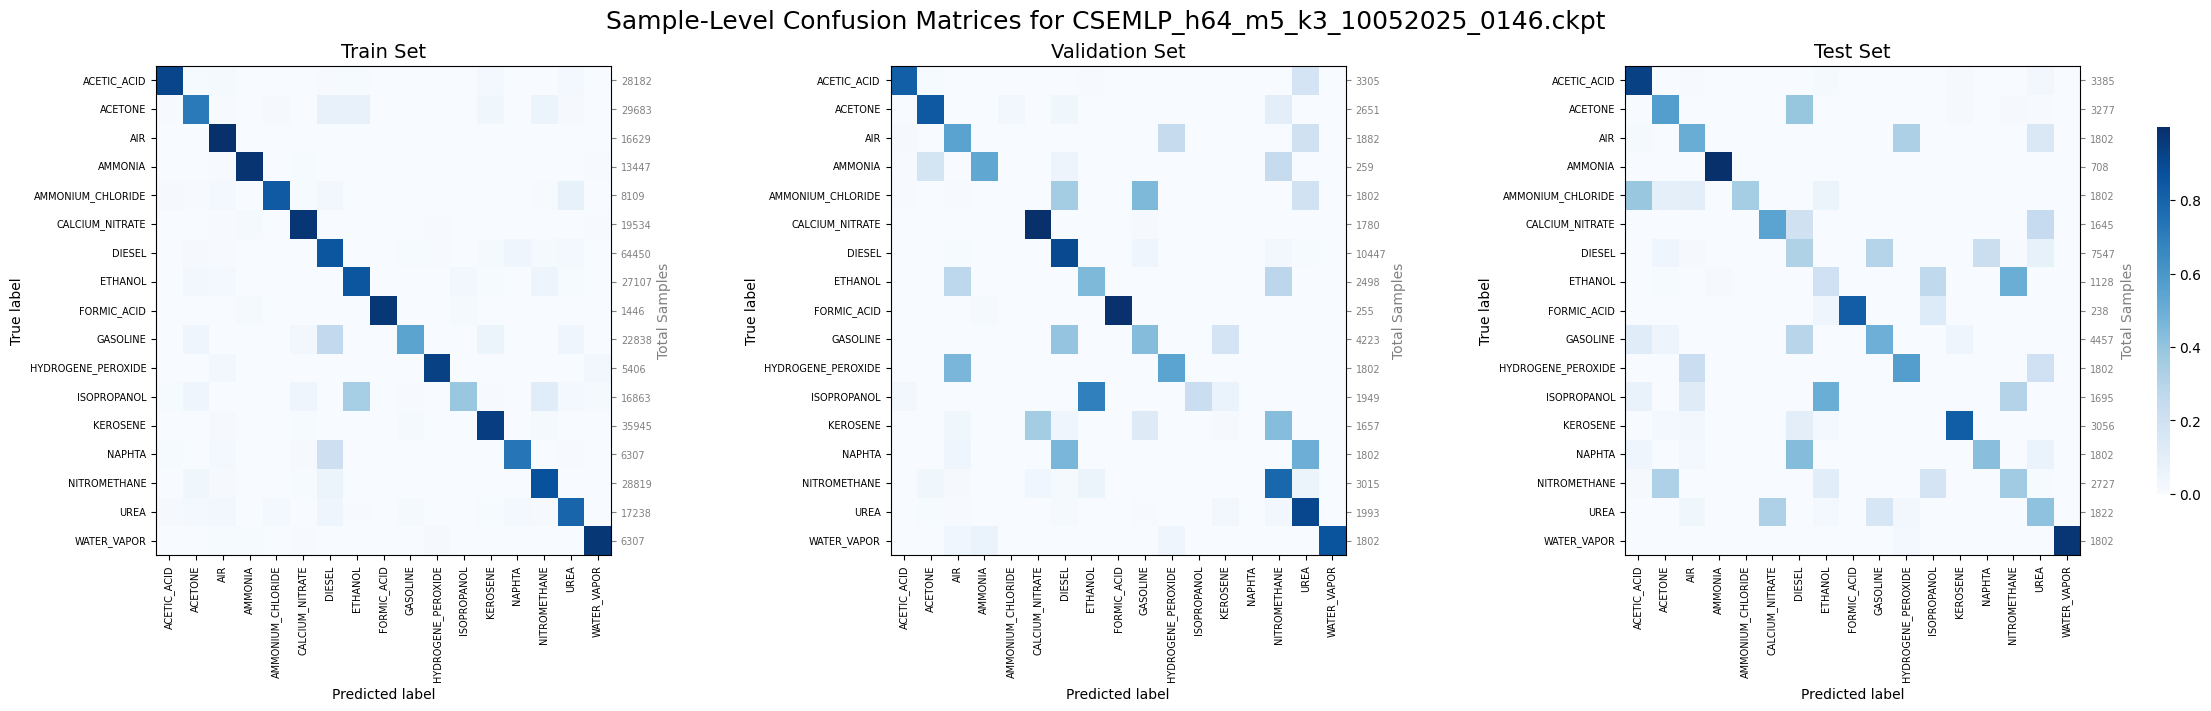

Train Performance: 0.8820058997050148
Validation Performance: 0.7073170731707317
Test Performance: 0.5853658536585366


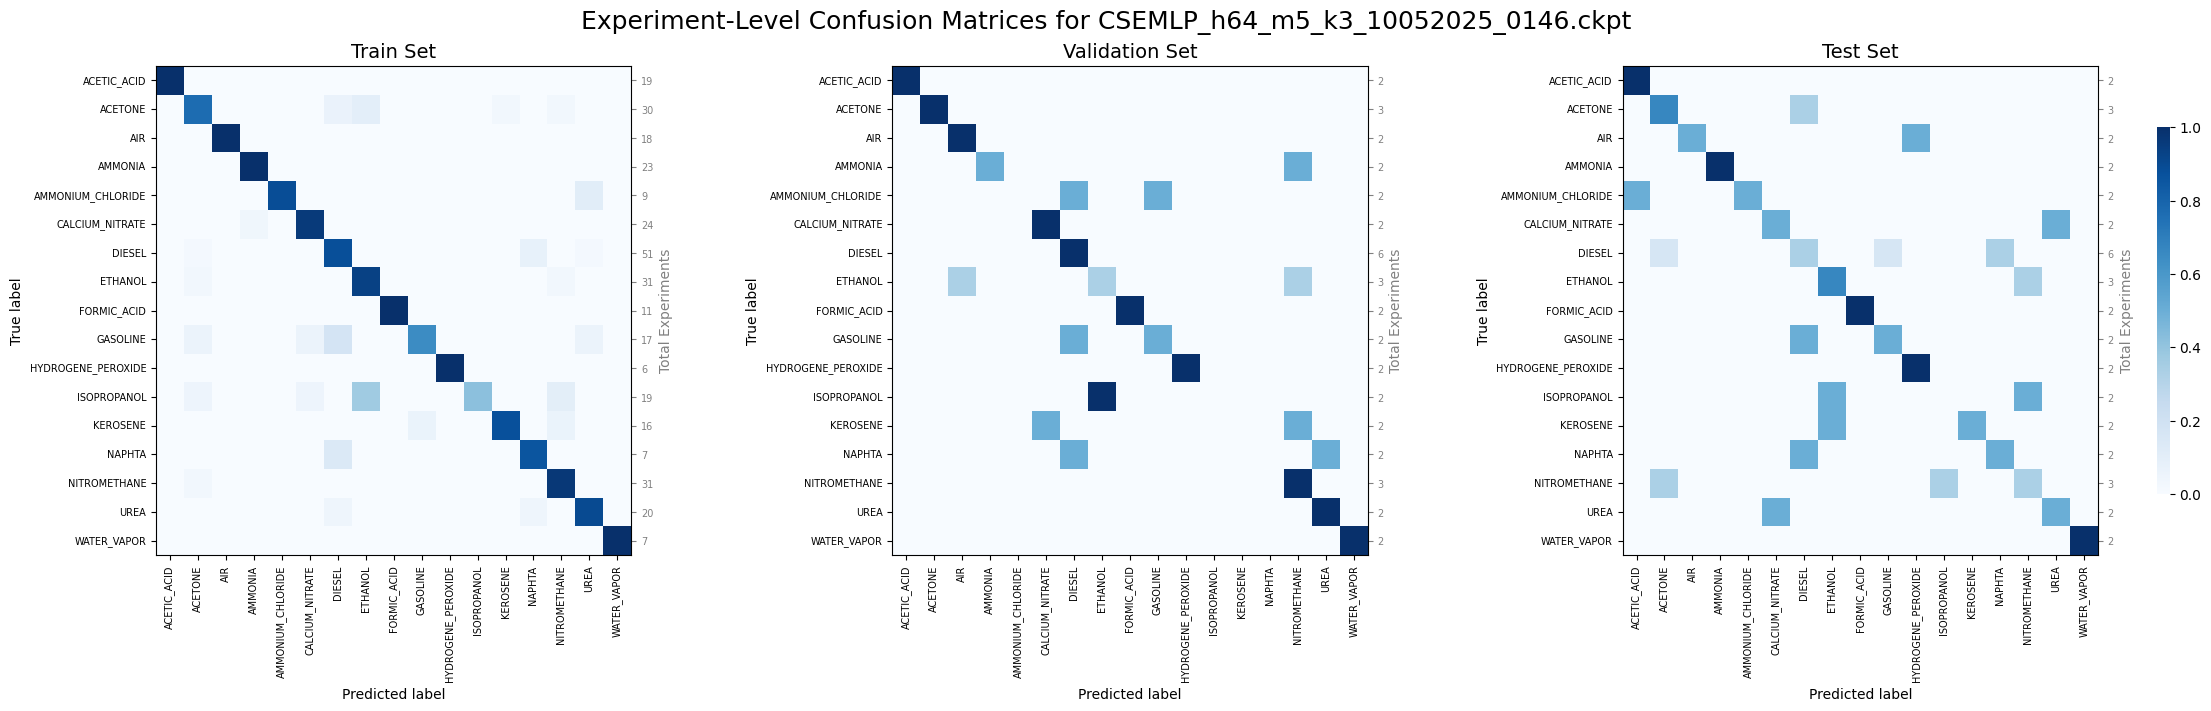

In [10]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

In [9]:
model_path = os.path.join(model_dir, "CSEMLP_h64_m5_k3_10052025_0146.ckpt")

sample_train_cm, train_exp_stats = get_stats_f1(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance_f1(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats_f1(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance_f1(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats_f1(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance_f1(test_exp_stats)

100%|██████████| 1272/1272 [00:56<00:00, 22.51it/s]


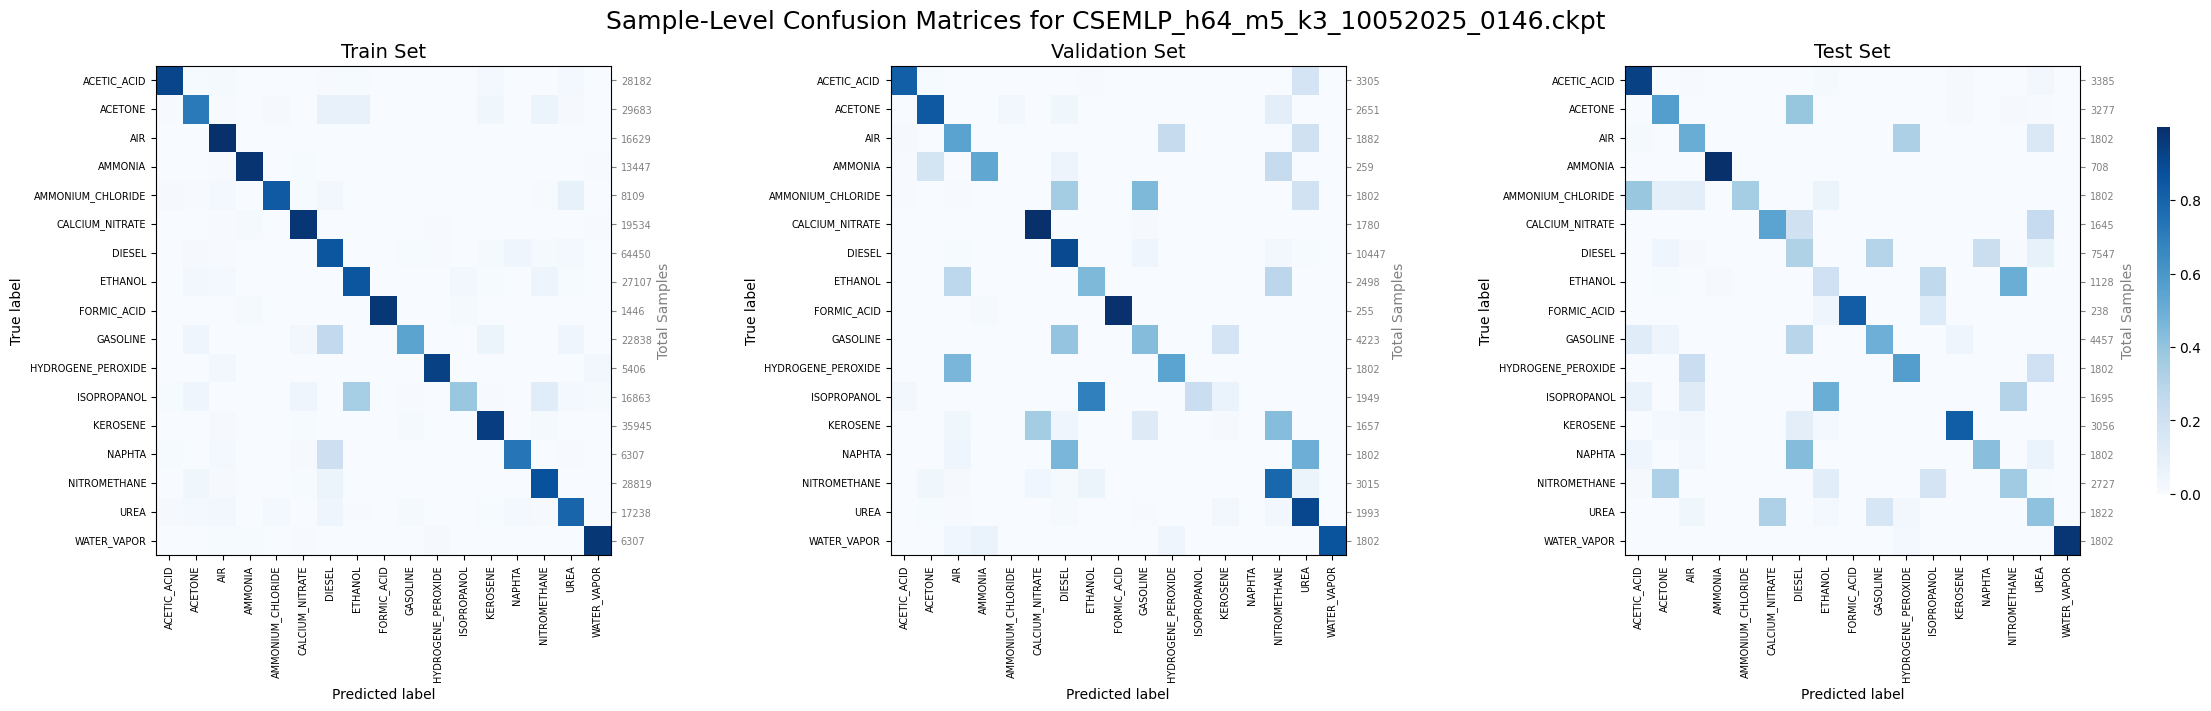

Train Performance: 0.887905604719764
Validation Performance: 0.7073170731707317
Test Performance: 0.5853658536585366


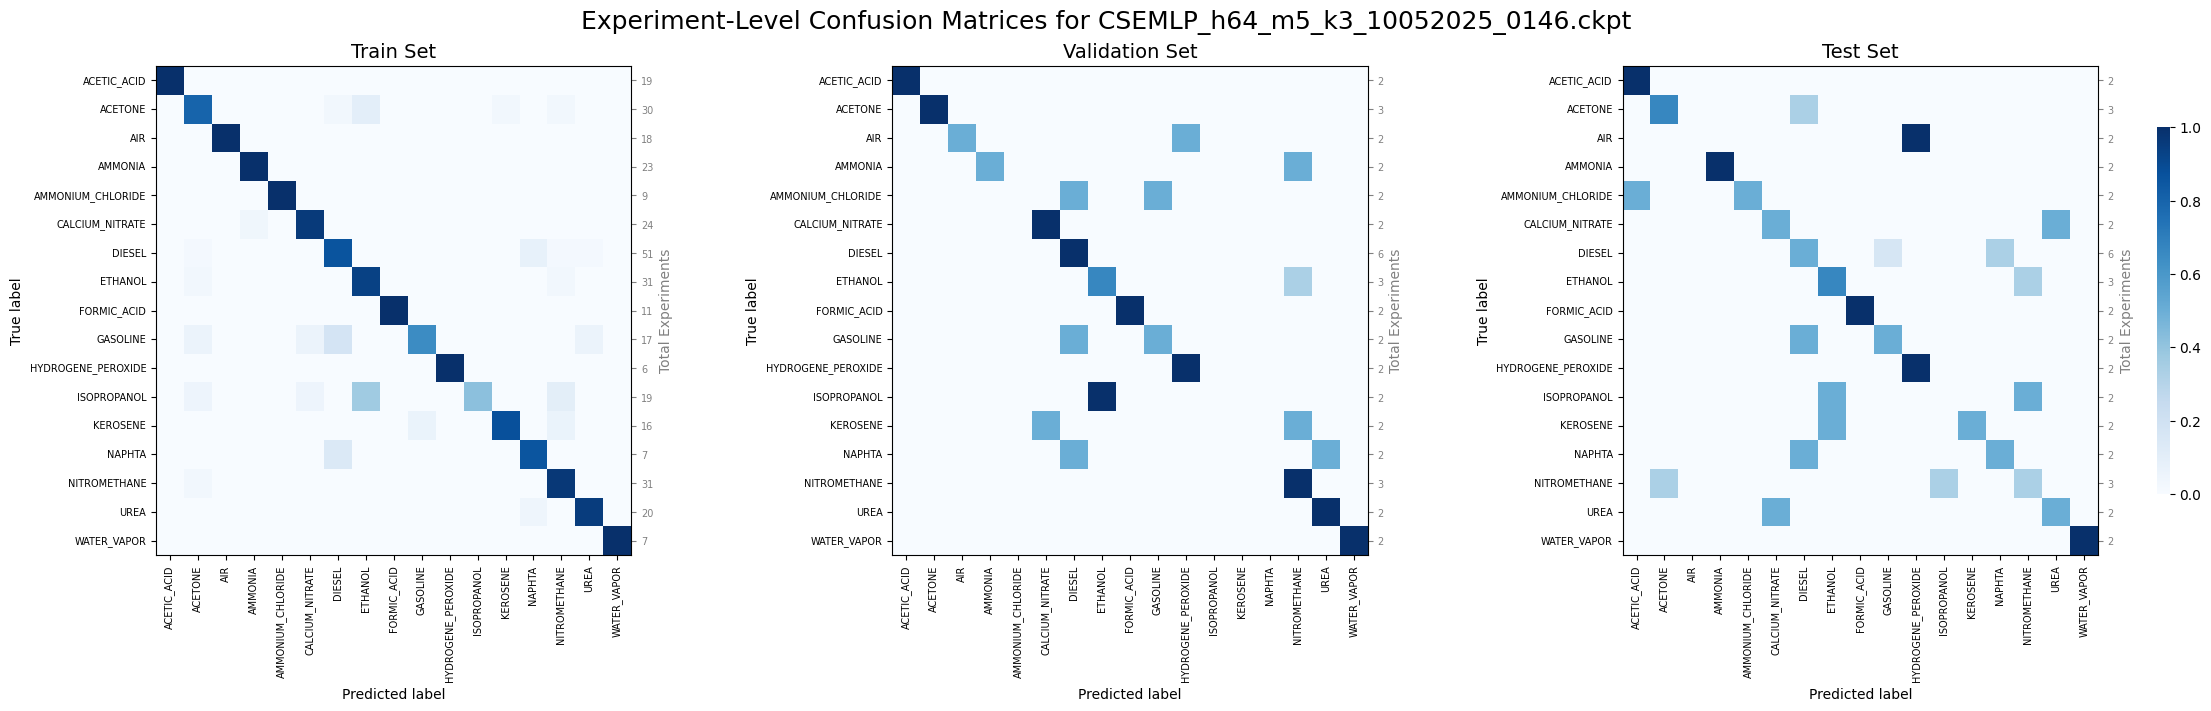

In [10]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

$
\text{Input: } \mathbb{R}^{100 \times 16}
\rightarrow \text{Column Selective Encoder}(1, 3) \rightarrow \mathbb{R}^{16+3}
\rightarrow \text{Linear}(19, 64)
\rightarrow [\text{Common MLP Block}]
$

In [11]:
model_path = os.path.join(model_dir, "CSEMLP_h64_m1_k3_10052025_0323.ckpt")

sample_train_cm, train_exp_stats = get_stats(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance(test_exp_stats)

100%|██████████| 1272/1272 [01:06<00:00, 19.12it/s]


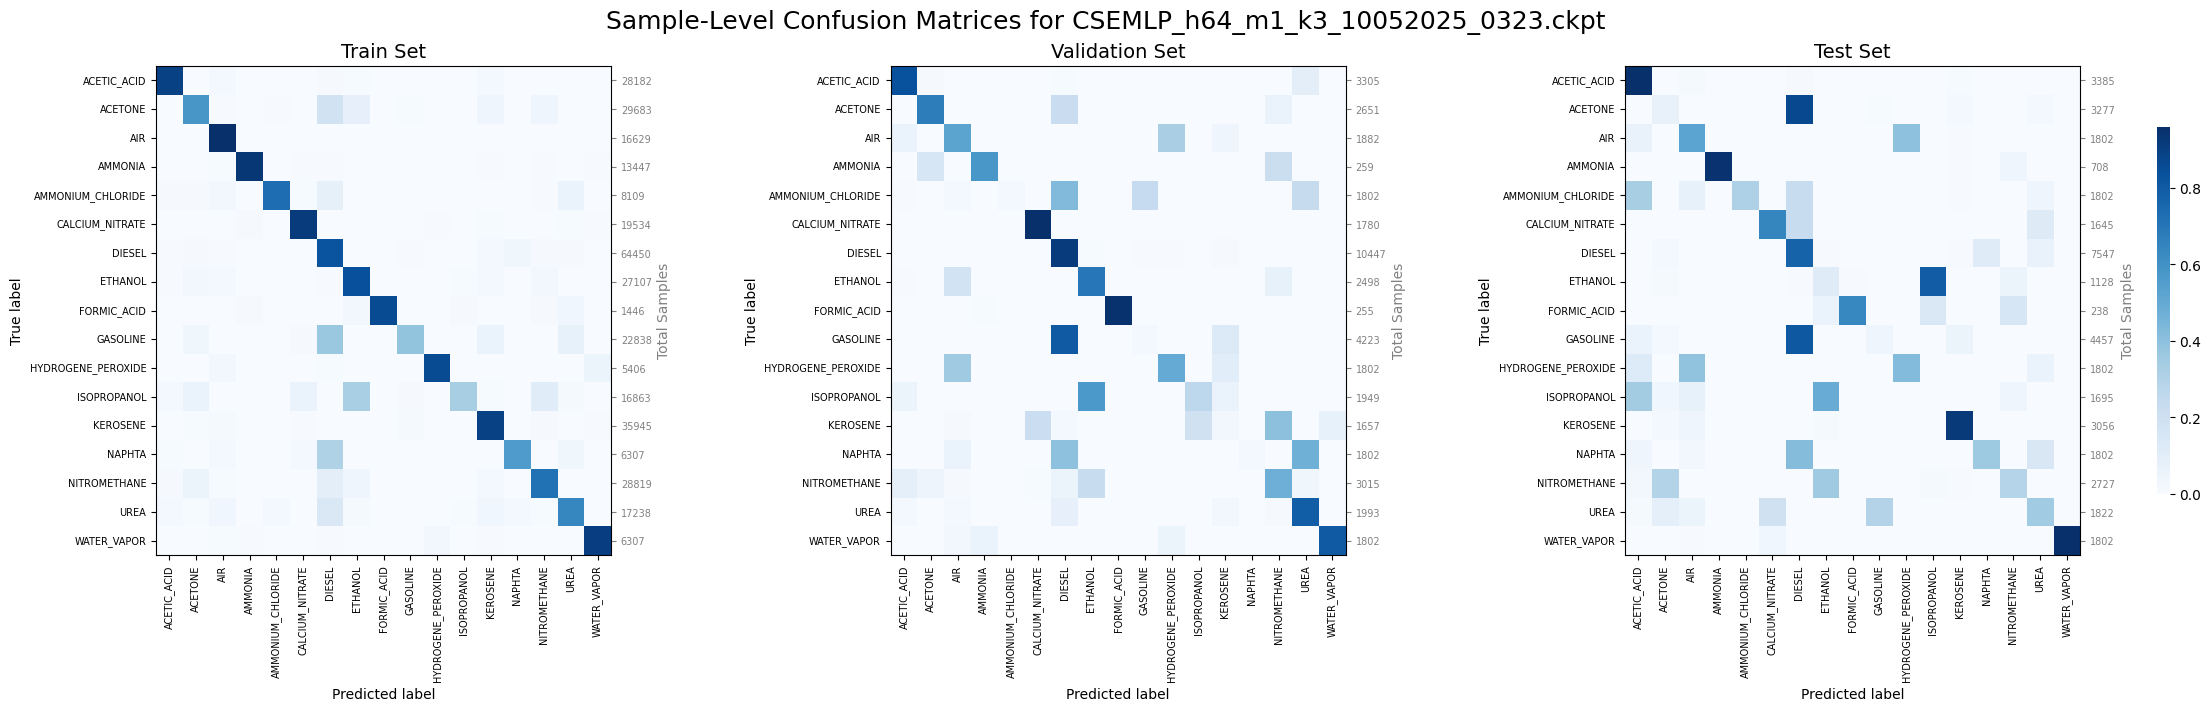

Train Performance: 0.8407079646017699
Validation Performance: 0.7317073170731707
Test Performance: 0.5853658536585366


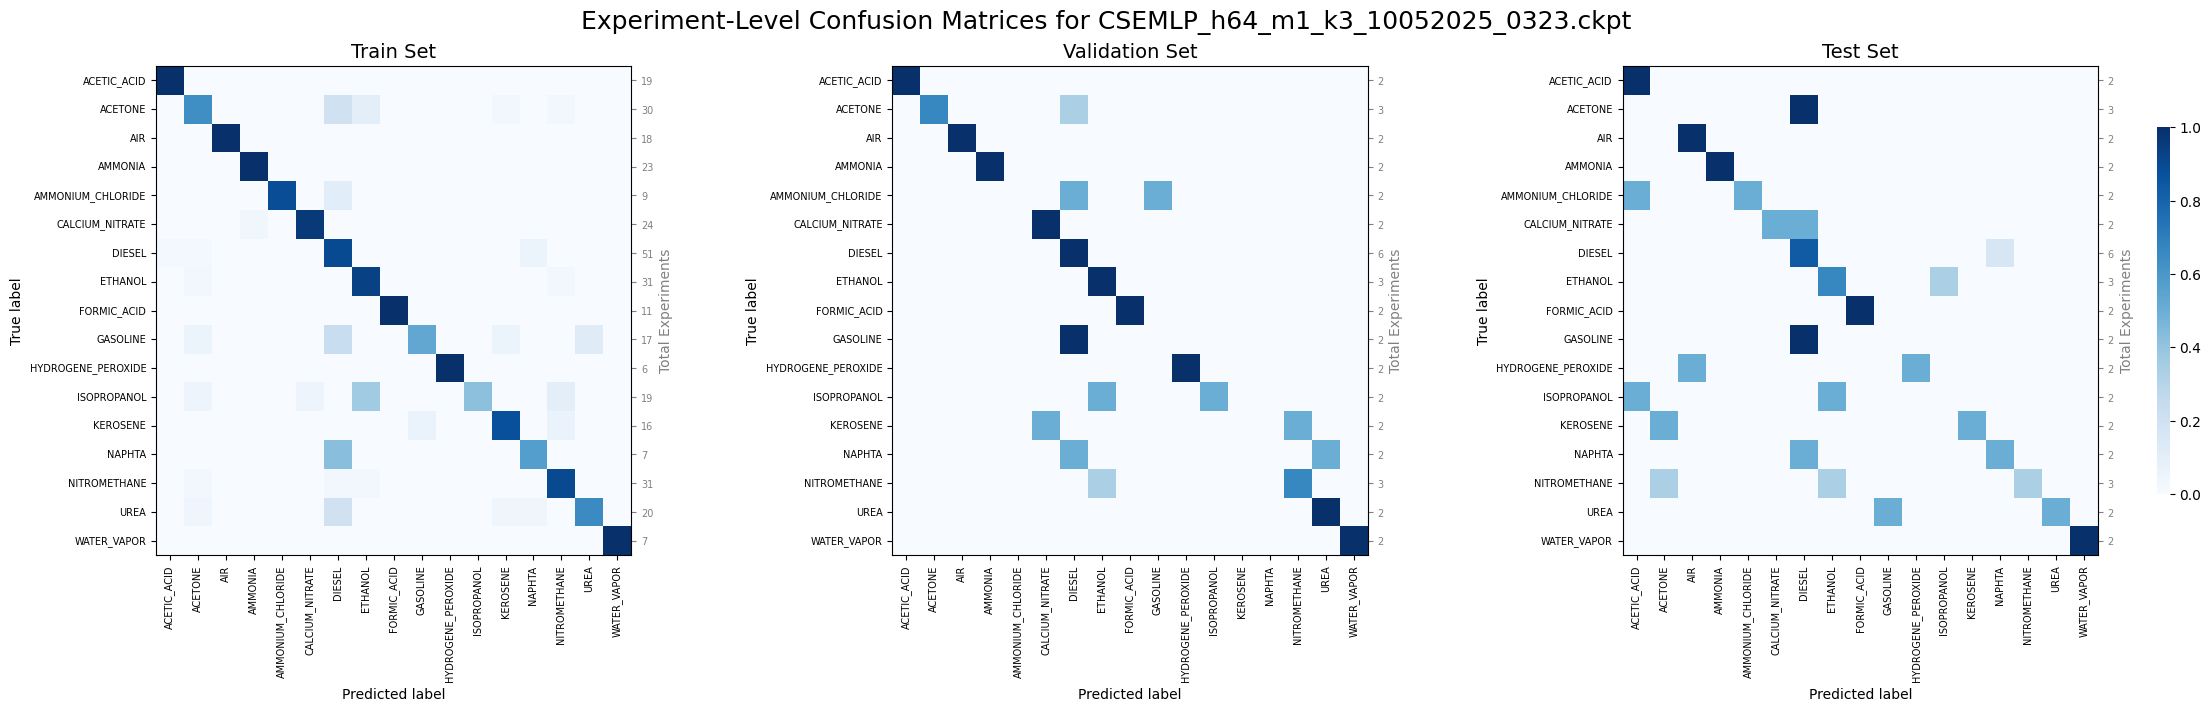

In [12]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

In [11]:
model_path = os.path.join(model_dir, "CSEMLP_h64_m1_k3_10052025_0323.ckpt")

sample_train_cm, train_exp_stats = get_stats_f1(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance_f1(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats_f1(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance_f1(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats_f1(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance_f1(test_exp_stats)

100%|██████████| 1272/1272 [01:16<00:00, 16.67it/s]


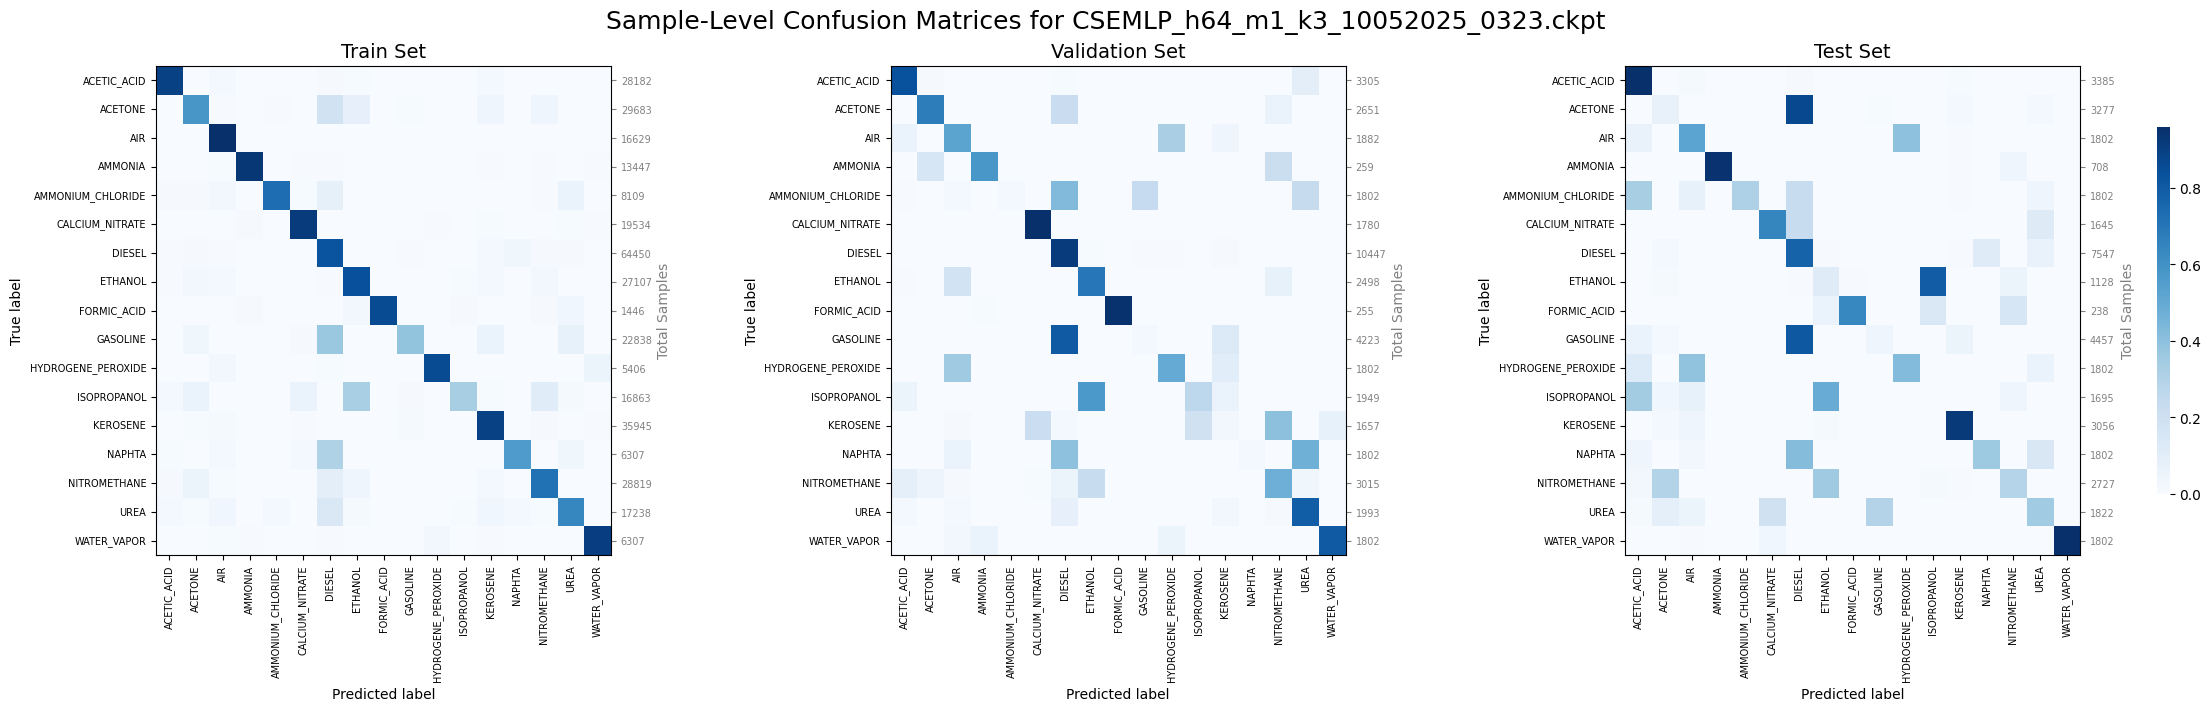

Train Performance: 0.8377581120943953
Validation Performance: 0.7317073170731707
Test Performance: 0.5365853658536586


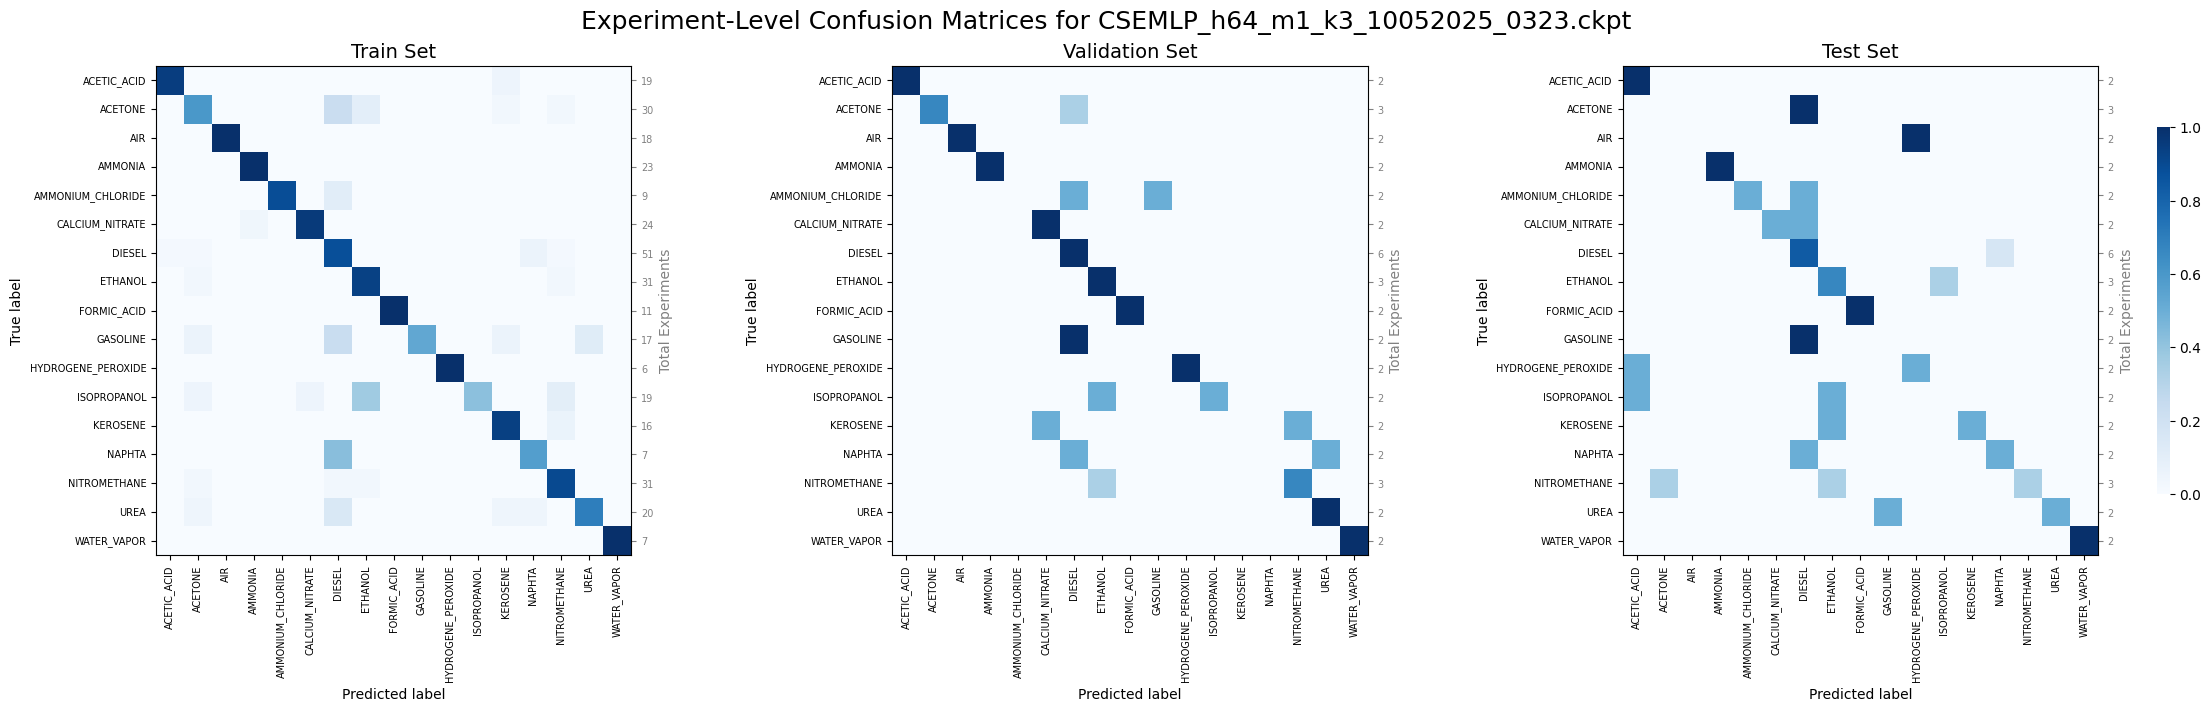

In [12]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

### CNN2D

In [ ]:
model_path = os.path.join(model_dir, "CNN2D_h64_c4_k2_10052025_1644.ckpt")

sample_train_cm, train_exp_stats = get_stats(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance(test_exp_stats)

100%|██████████| 1272/1272 [00:58<00:00, 21.68it/s]


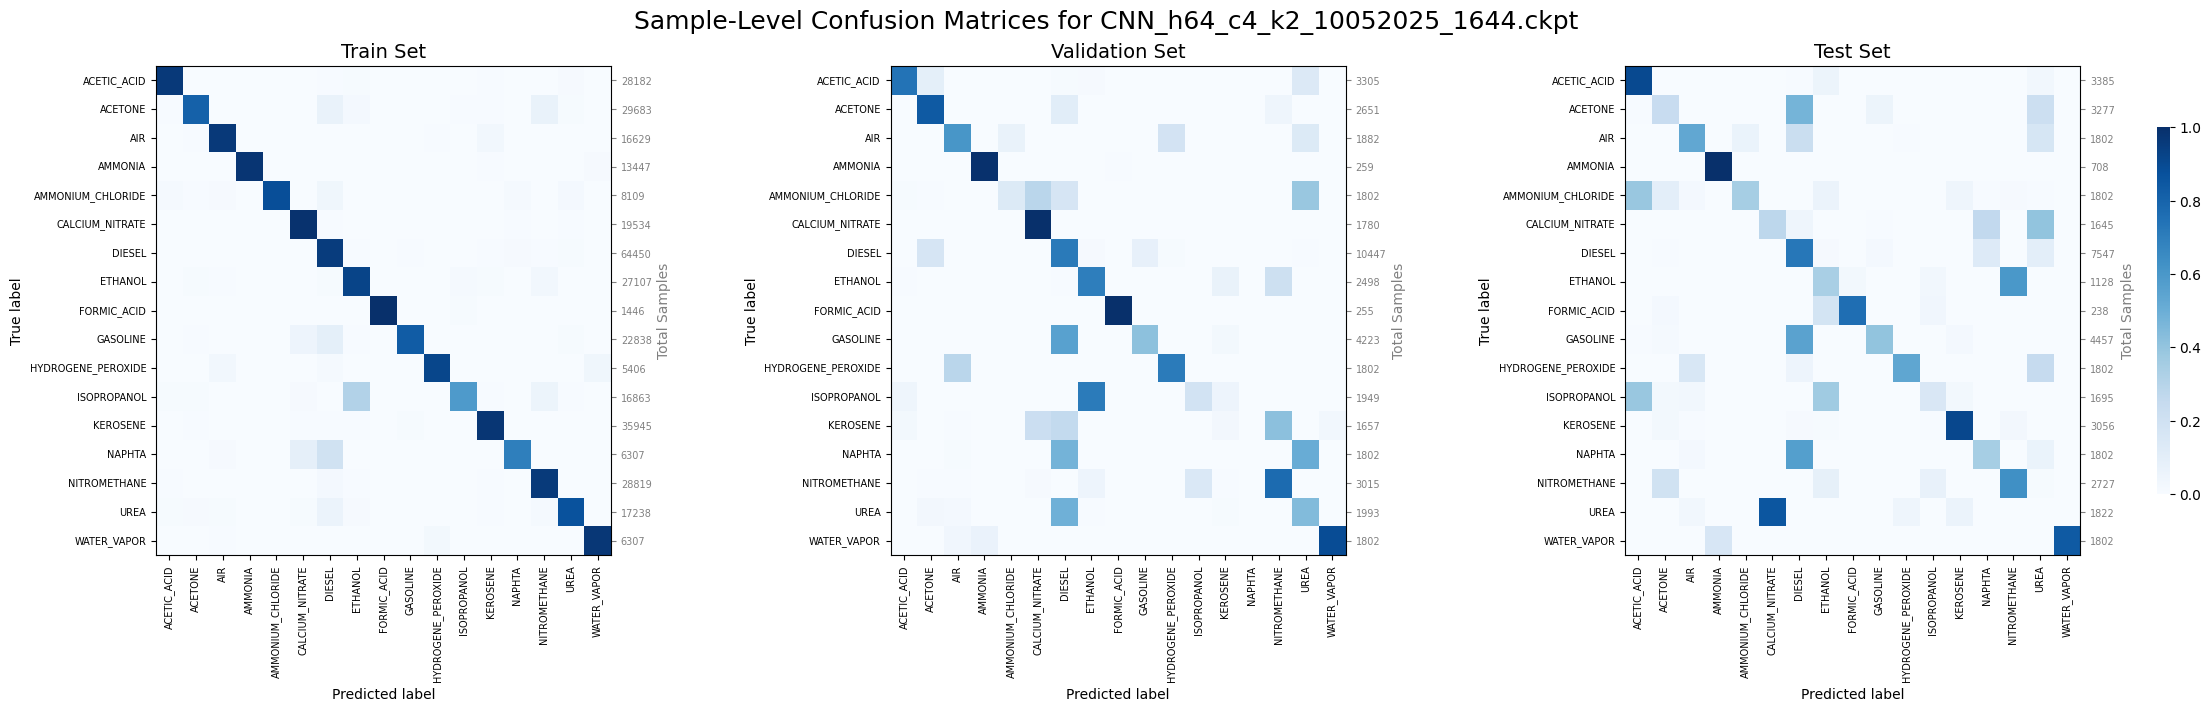

Train Performance: 0.9528023598820059
Validation Performance: 0.6829268292682927
Test Performance: 0.6097560975609756


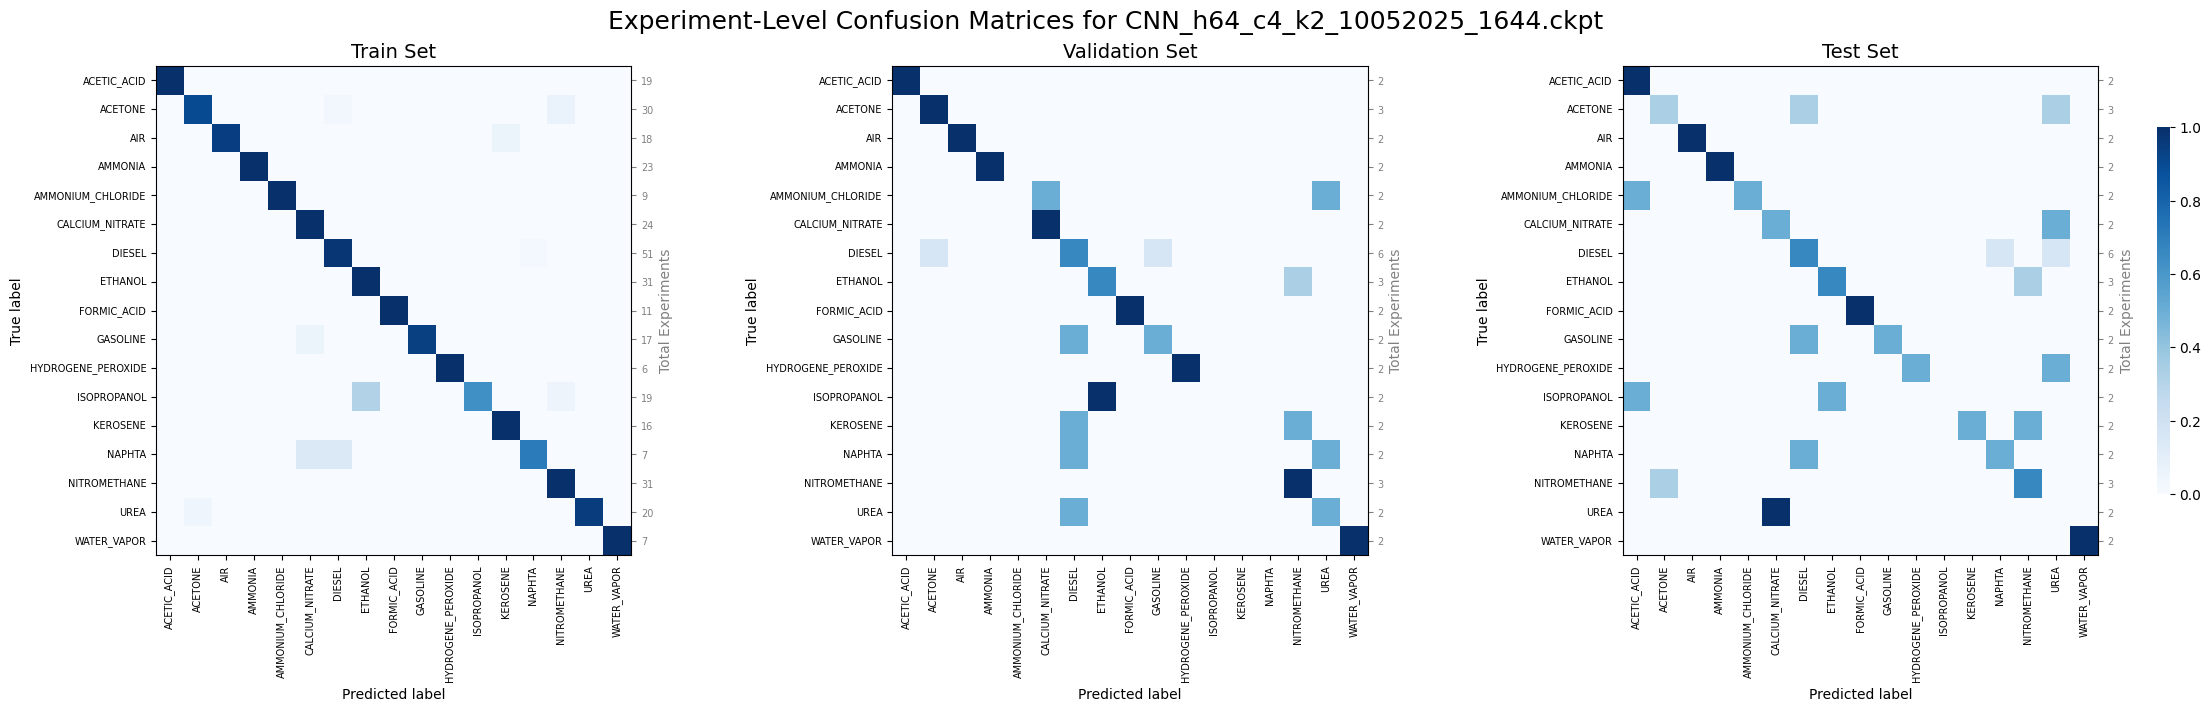

In [14]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

In [13]:
model_path = os.path.join(model_dir, "CNN_h64_c4_k2_10052025_1644.ckpt")

sample_train_cm, train_exp_stats = get_stats_f1(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance_f1(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats_f1(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance_f1(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats_f1(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance_f1(test_exp_stats)

100%|██████████| 1272/1272 [01:14<00:00, 17.03it/s]


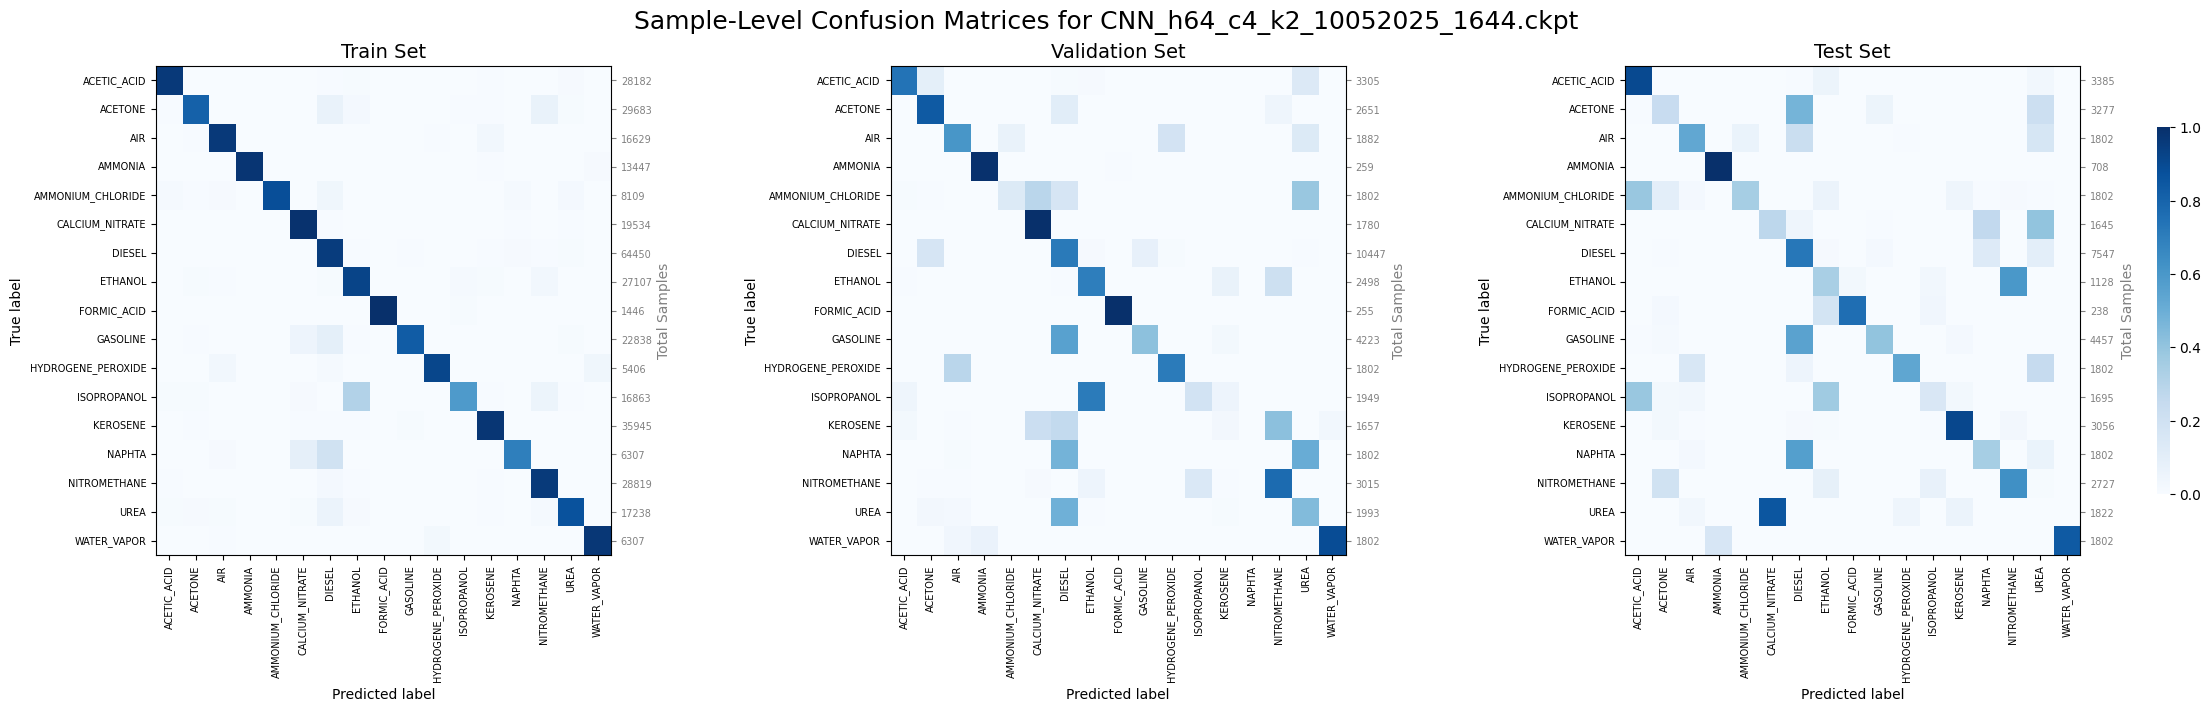

Train Performance: 0.9528023598820059
Validation Performance: 0.6829268292682927
Test Performance: 0.5365853658536586


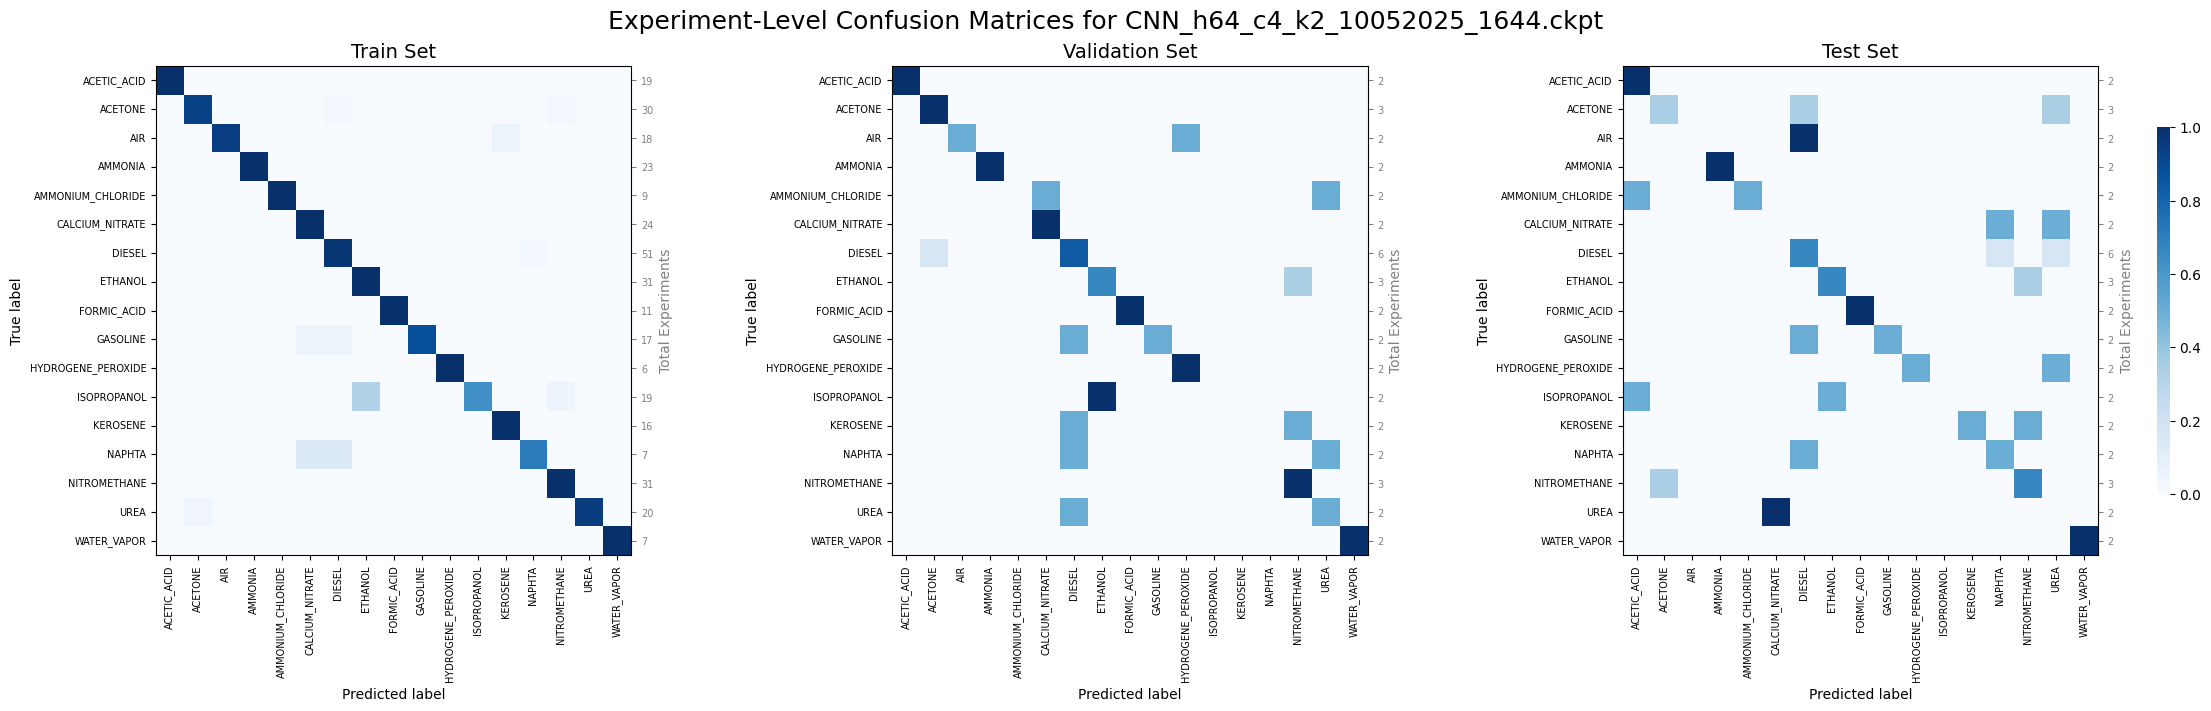

In [14]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

### CNN1D

In [3]:
model_path = os.path.join(model_dir, "CNN1D_h64_c4_k3_19062025_0216.ckpt")

sample_train_cm, train_exp_stats = get_stats(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance(test_exp_stats)

100%|██████████| 1272/1272 [01:05<00:00, 19.46it/s]


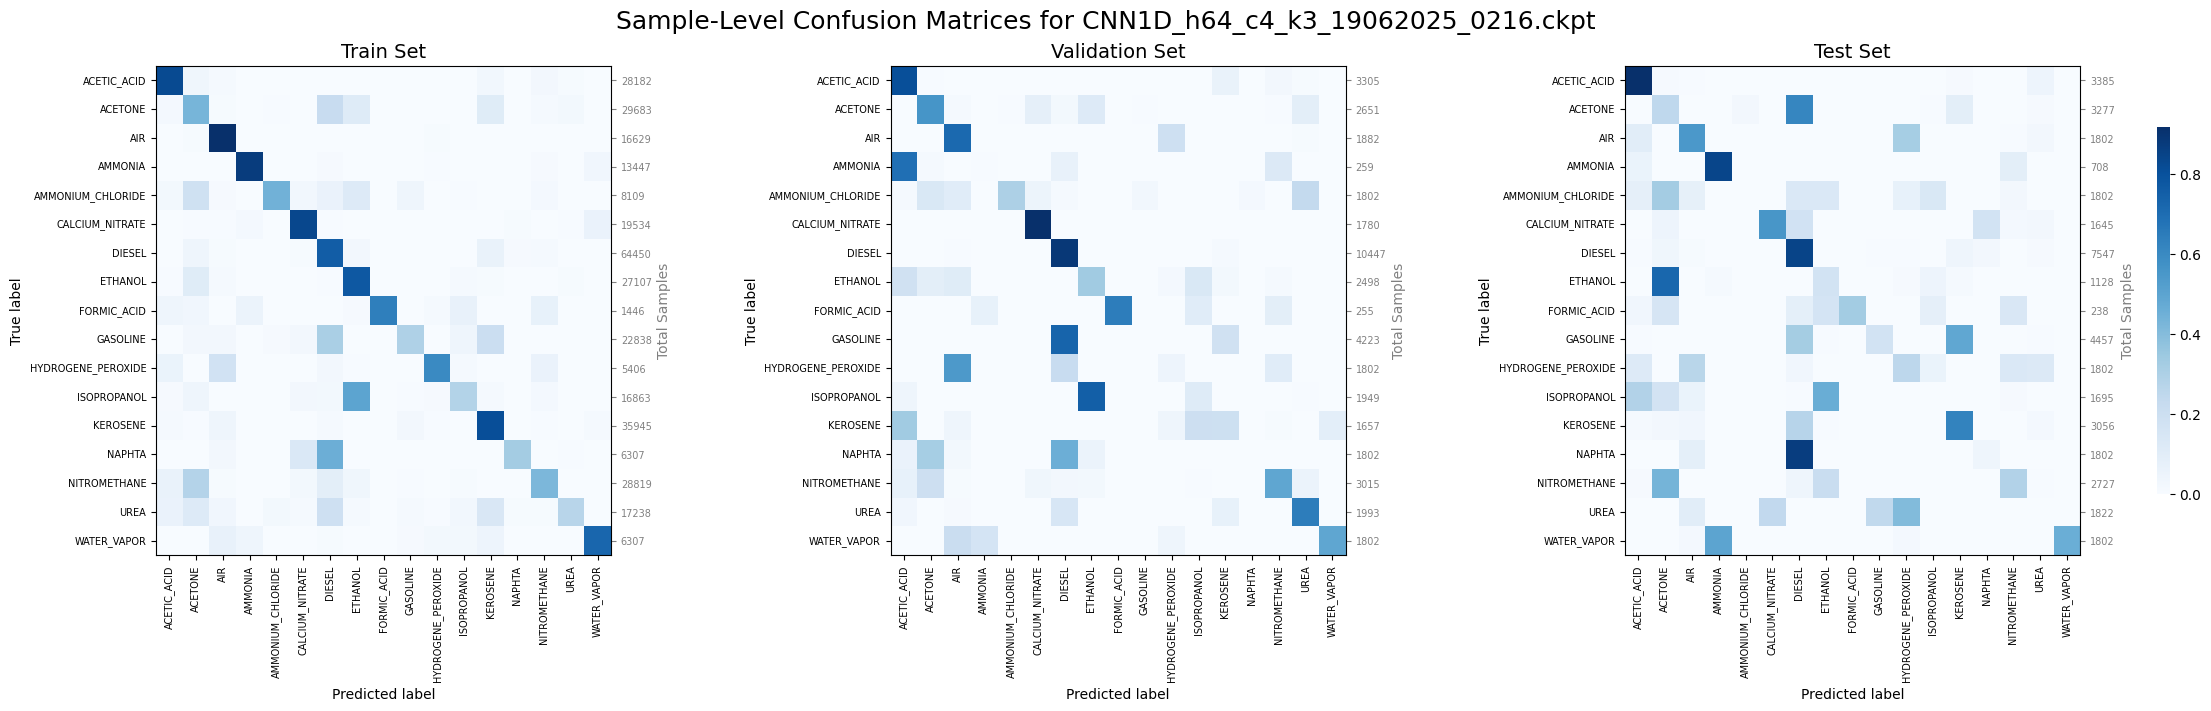

Train Performance: 0.696165191740413
Validation Performance: 0.5609756097560976
Test Performance: 0.4634146341463415


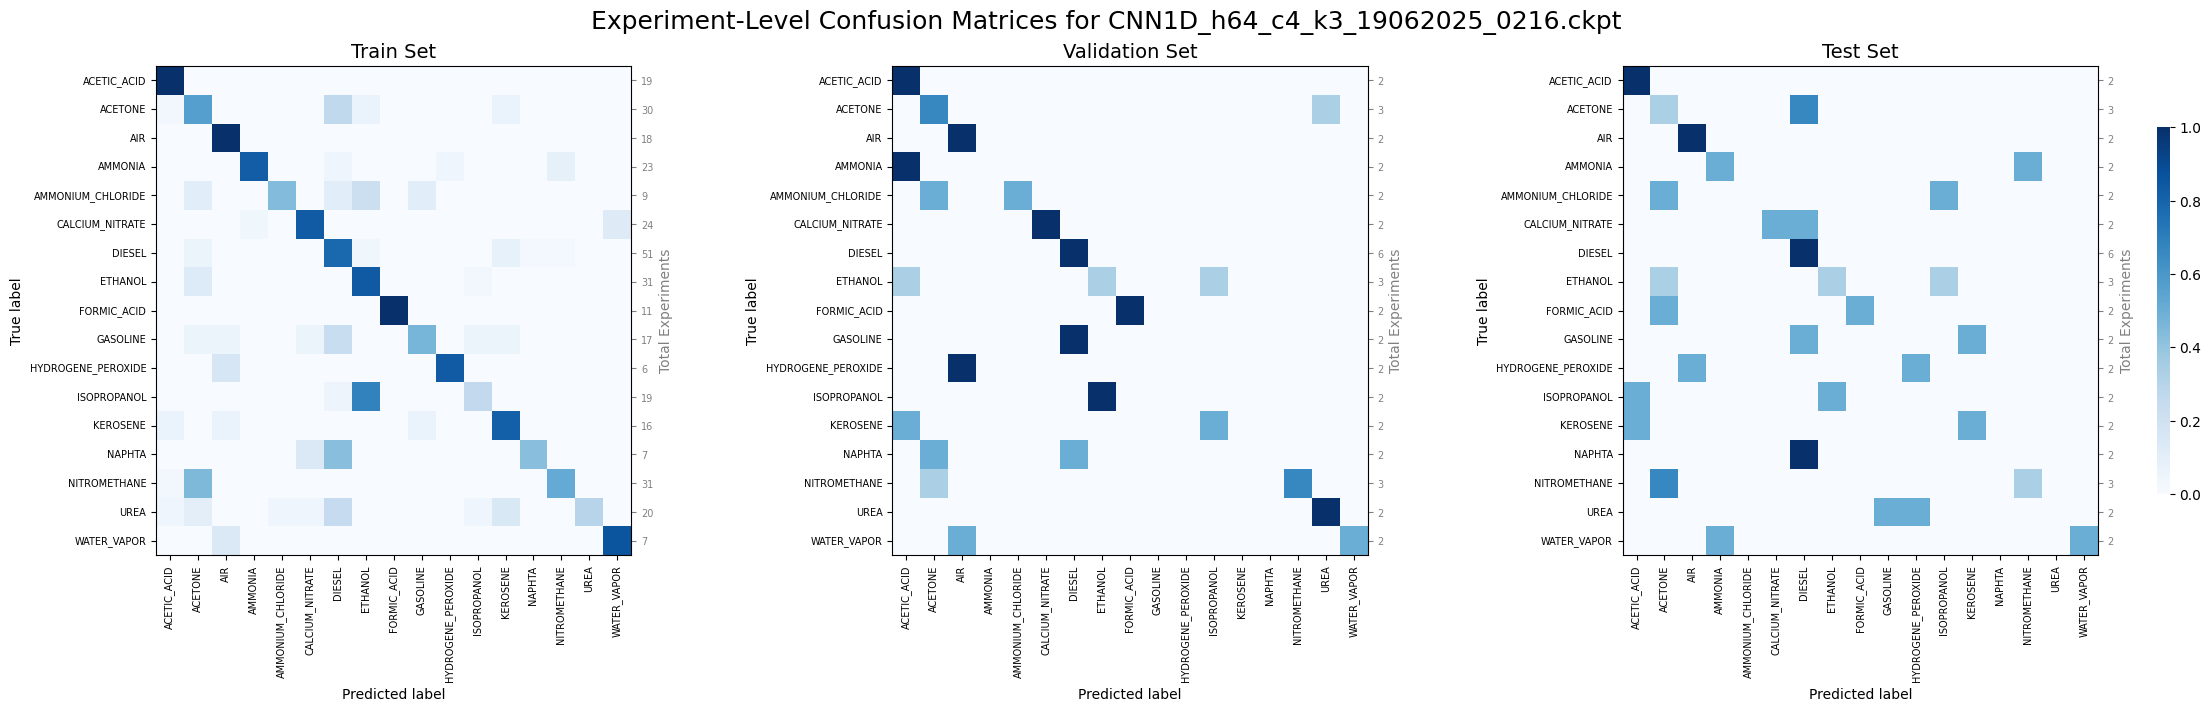

In [4]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)

### GRU RNN

In [3]:
model_path = os.path.join(model_dir, "RNN_GRU_h64_23052025_1754.ckpt")

sample_train_cm, train_exp_stats = get_stats(model_path, train_loader, len(label_encoder.classes_), device)
train_performance, train_majority_votes, exp_train_cm = compute_experiment_performance(train_exp_stats)

sample_val_cm, val_exp_stats = get_stats(model_path, val_loader, len(label_encoder.classes_), device)
val_performance, val_majority_votes, exp_val_cm = compute_experiment_performance(val_exp_stats)

sample_test_cm, test_exp_stats = get_stats(model_path, test_loader, len(label_encoder.classes_), device)
test_performance, test_majority_votes, exp_test_cm = compute_experiment_performance(test_exp_stats)

100%|██████████| 1272/1272 [00:57<00:00, 22.07it/s]


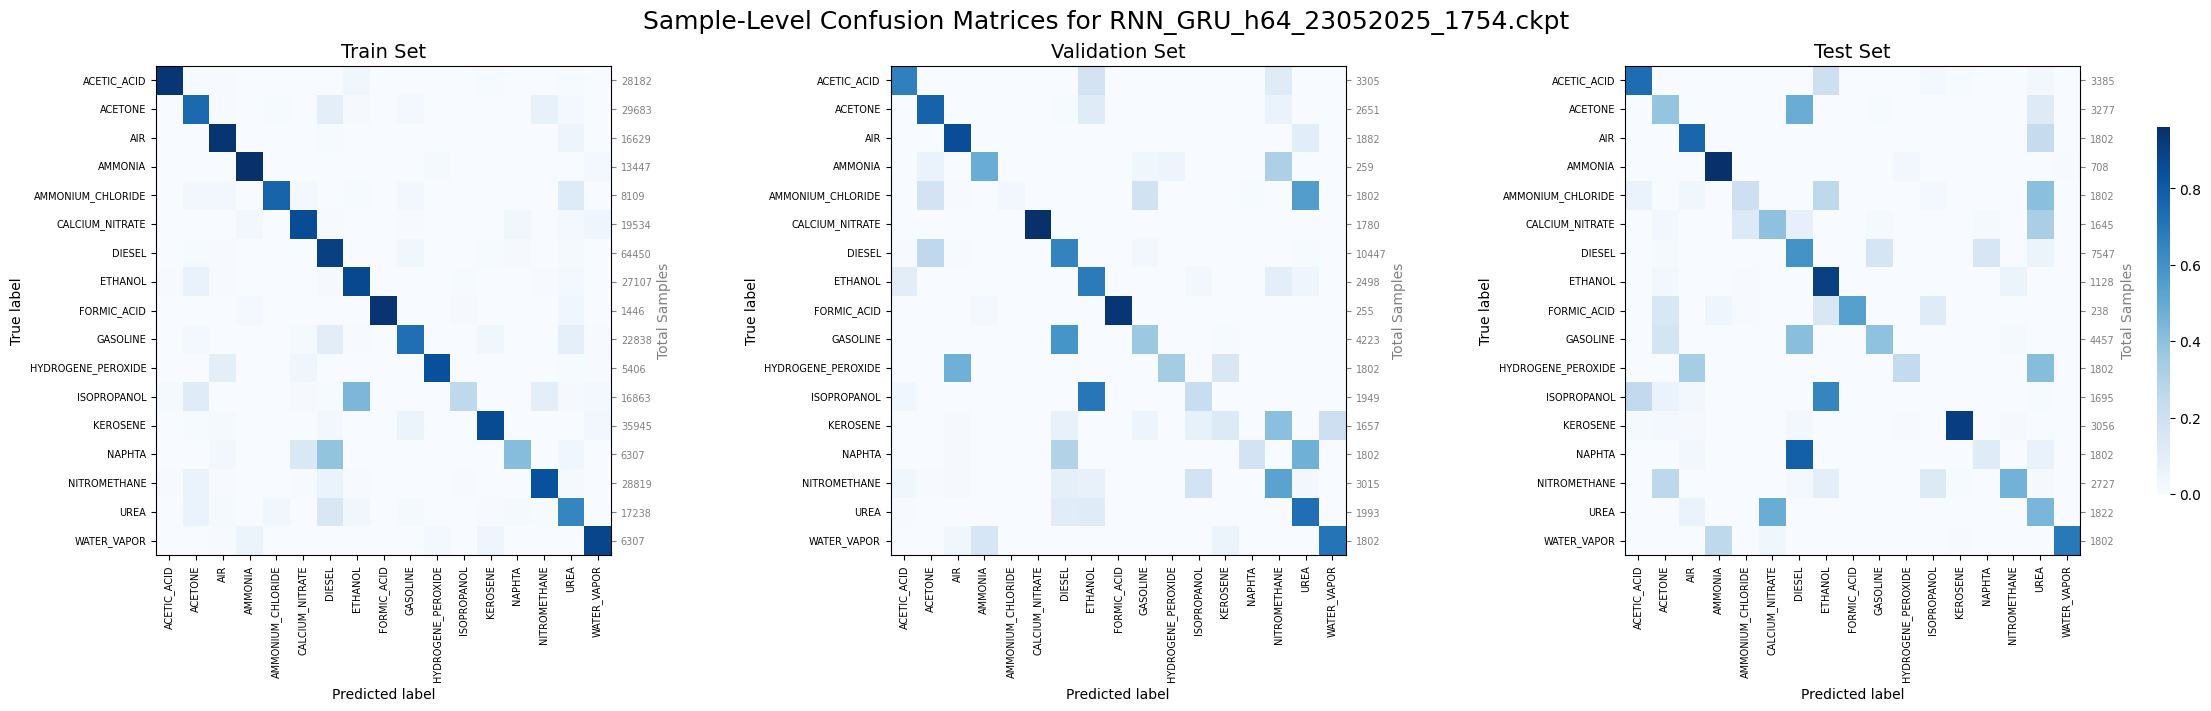

Train Performance: 0.855457227138643
Validation Performance: 0.6585365853658537
Test Performance: 0.5609756097560976


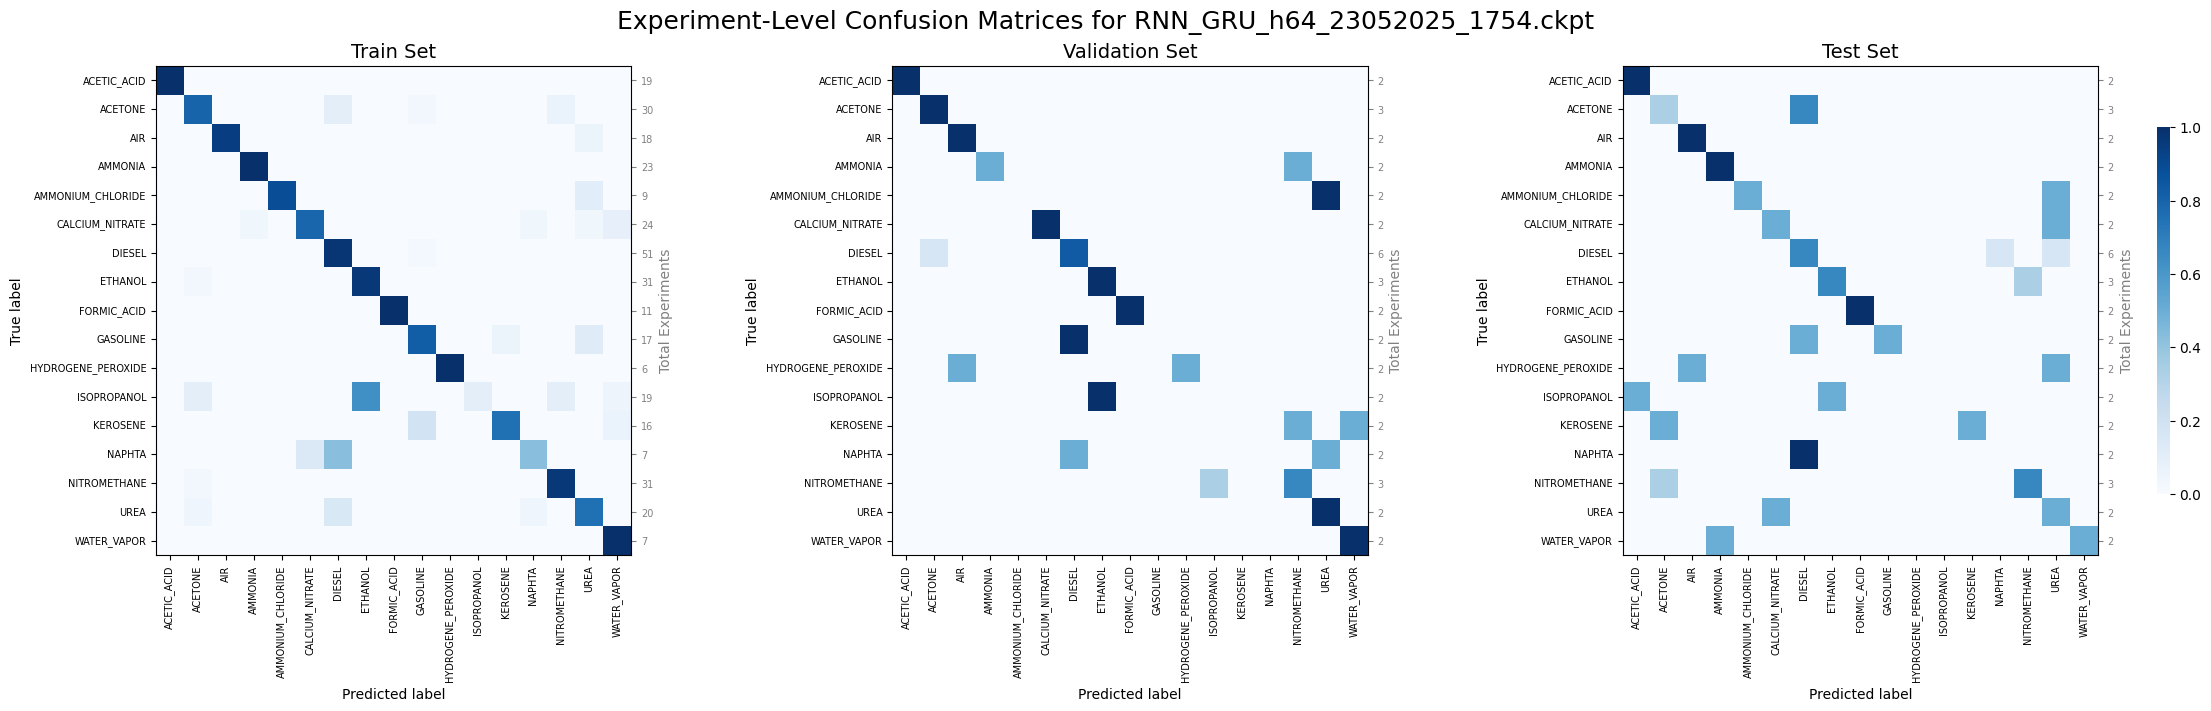

In [4]:
# Plotting the sample-level confusion matrices
plot_confusion_matrices(
    sample_train_cm,
    sample_val_cm,
    sample_test_cm,
    suptitle=f'Sample-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Sample"
)

print("Train Performance:", train_performance)
print("Validation Performance:", val_performance)
print("Test Performance:", test_performance)

# Plotting the experiment-level confusion matrices
plot_confusion_matrices(
    exp_train_cm,
    exp_val_cm,
    exp_test_cm,
    suptitle=f'Experiment-Level Confusion Matrices for {os.path.basename(model_path)}',
    class_names=label_encoder.classes_,
    cmap='Blues',
    cm_type="Experiment"
)